In [8]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    if labels is not None:
        labels = labels.reshape(-1)
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),colors=('gray','blue'),levels=[-1,0,1])

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

def gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
         #melange de 2 gaussiennes
        xpos=np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//2)
        xneg=np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//2)
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))
    if data_type==1:
        #melange de 4 gaussiennes
        xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))

    if data_type==2:
        #echiquier
        data=np.reshape(np.random.uniform(-4,4,2*nbex),(nbex,2))
        y=np.ceil(data[:,0])+np.ceil(data[:,1])
        y=2*(y % 2)-1
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y.reshape(-1, 1)

UsageError: Line magic function `%matplolib` not found.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def mse(w,x,y):
    """
    vecteur(d,1) * matrice(n,d) * vecteur(n,1) -> vecteur(n,1)
    """
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return ((x@w) - y)**2

def mse_grad(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return 2*x*((x@w) - y)


def reglog(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return np.log(1 + np.exp(-(y*(x@w))))

def reglog_grad(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return -x*y / (1 + np.exp(y * (x@w)))

def check_fonctions():
    ## On fixe la seed de l'aléatoire pour vérifier les fonctions
    np.random.seed(0)
    datax, datay = gen_arti(epsilon=0.1)
    wrandom = np.random.randn(datax.shape[1],1)
    assert(np.isclose(mse(wrandom,datax,datay).mean(),0.54731,rtol=1e-4))
    assert(np.isclose(reglog(wrandom,datax,datay).mean(), 0.57053,rtol=1e-4))
    assert(np.isclose(mse_grad(wrandom,datax,datay).mean(),-1.43120,rtol=1e-4))
    assert(np.isclose(reglog_grad(wrandom,datax,datay).mean(),-0.42714,rtol=1e-4))
    np.random.seed()
    
def descente_gradient(datax,datay,f_loss,f_grad,eps=1e-2,iteration=1000):
    W = np.random.randn(datax.shape[1],1)
    liste_w = []
    liste_error = []
    for i in range(iteration):
        W = W - eps*f_grad(W,datax,datay).mean(axis=0).reshape(-1,1)
        liste_w.append(W)
        liste_error.append(np.mean(f_loss(W,datax,datay)))
    return W, np.array(liste_w), np.array(liste_error)


In [3]:
check_fonctions()
# ne retourne pas d'erreur

# Regression lineaire

# Données non bruitées

epsilon : 0.001 et nb_itération : 10


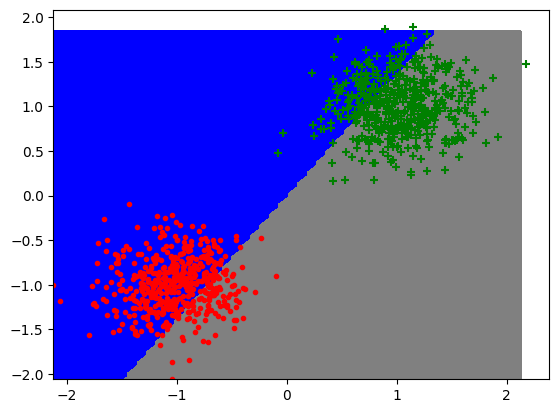

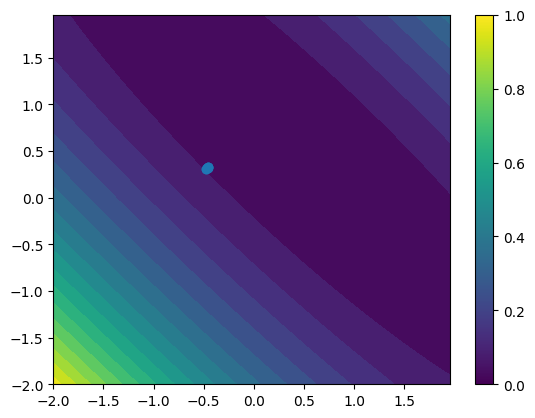

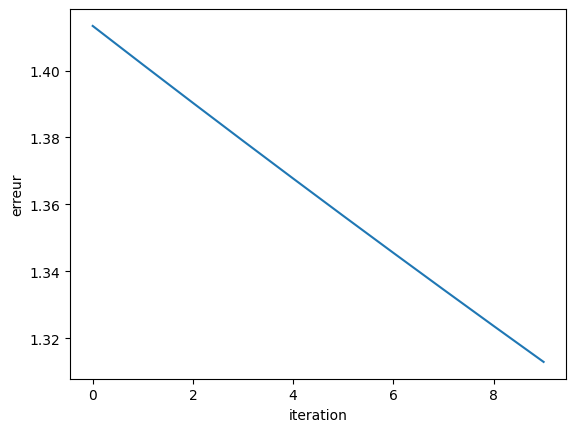

epsilon : 0.001 et nb_itération : 100


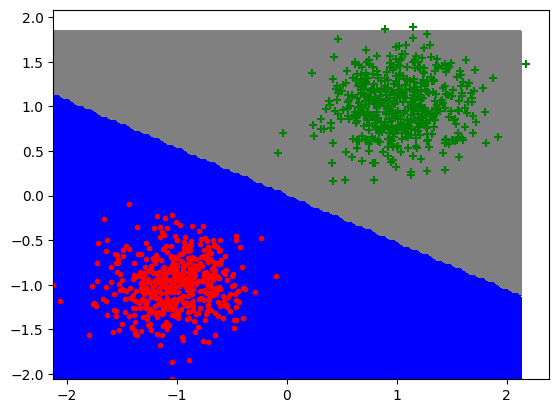

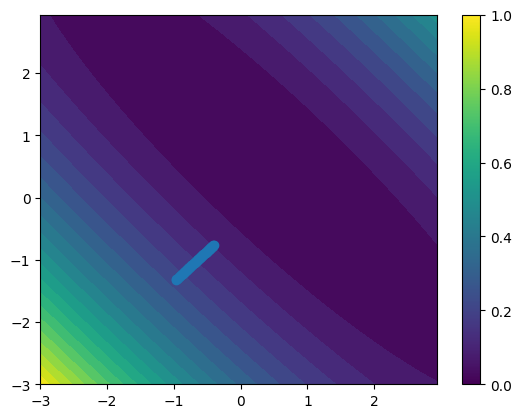

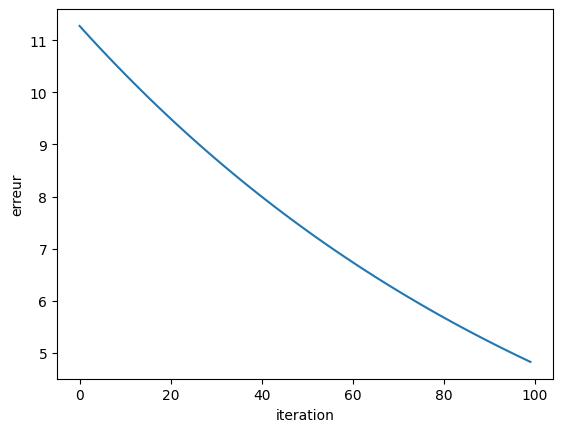

epsilon : 0.001 et nb_itération : 1000


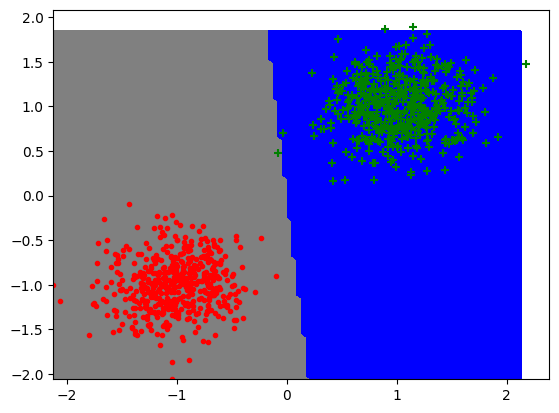

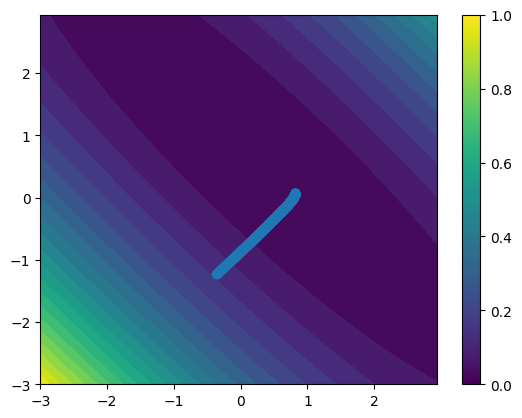

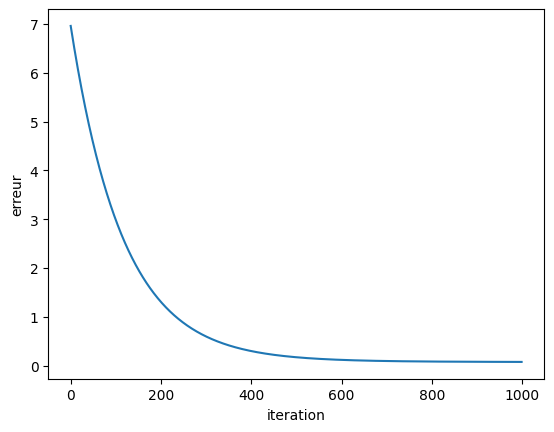

epsilon : 0.001 et nb_itération : 10000


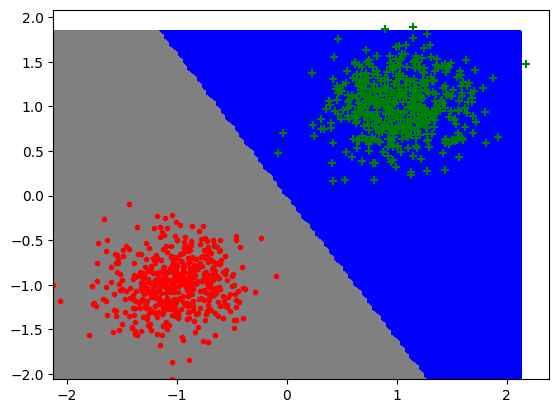

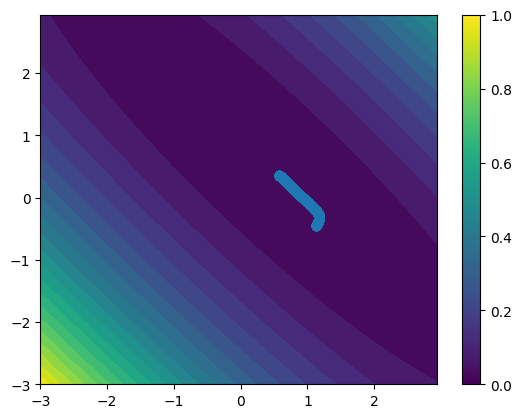

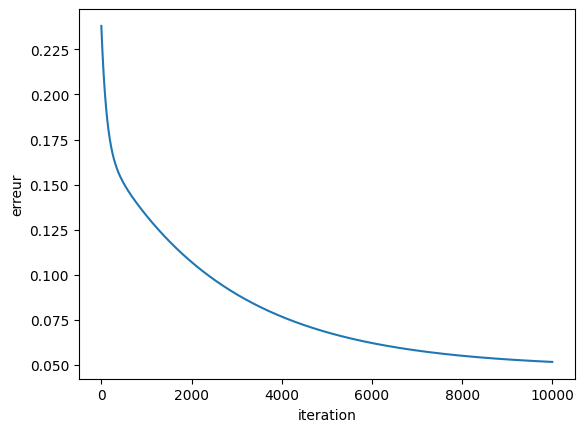

epsilon : 0.01 et nb_itération : 10


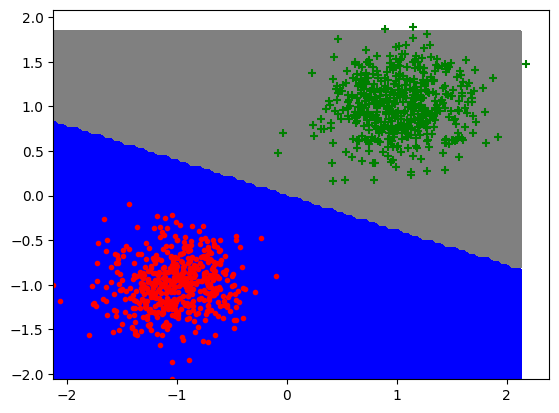

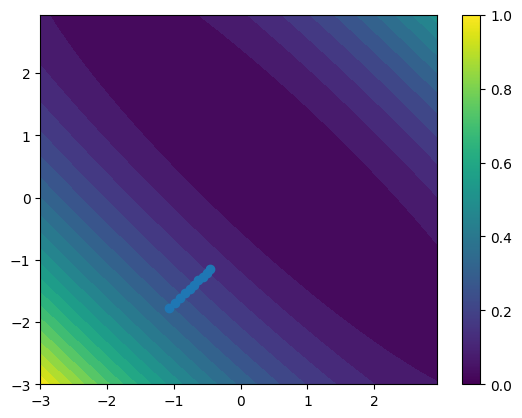

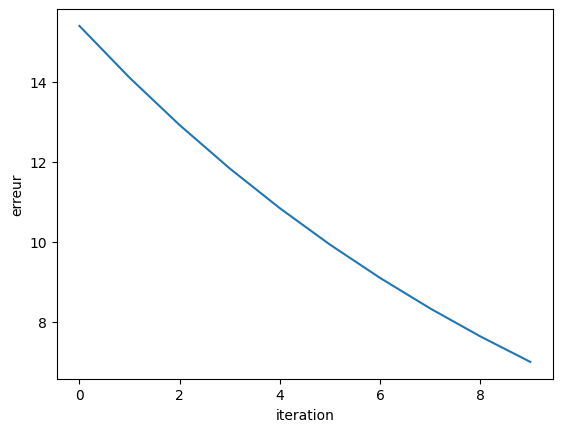

epsilon : 0.01 et nb_itération : 100


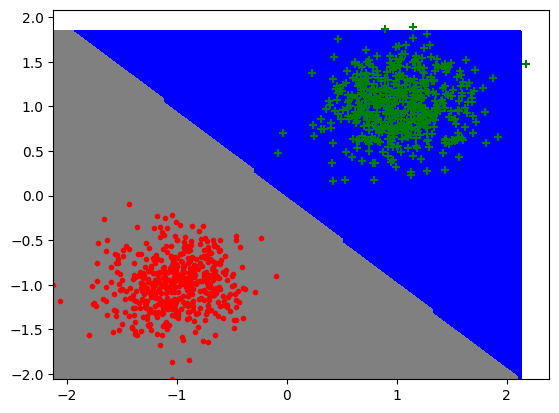

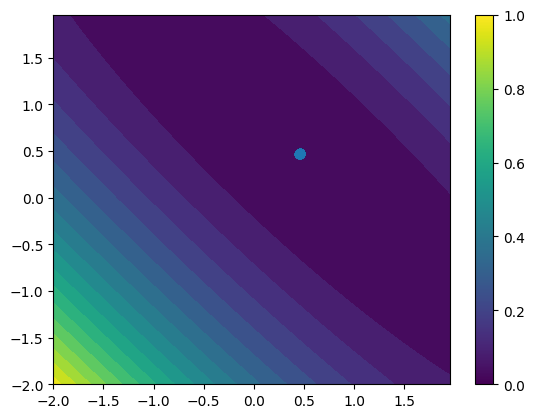

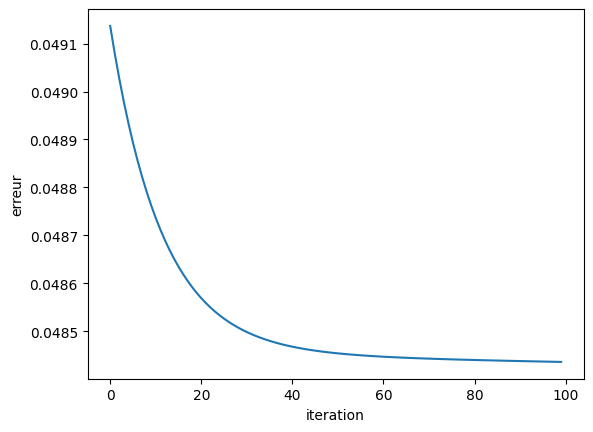

epsilon : 0.01 et nb_itération : 1000


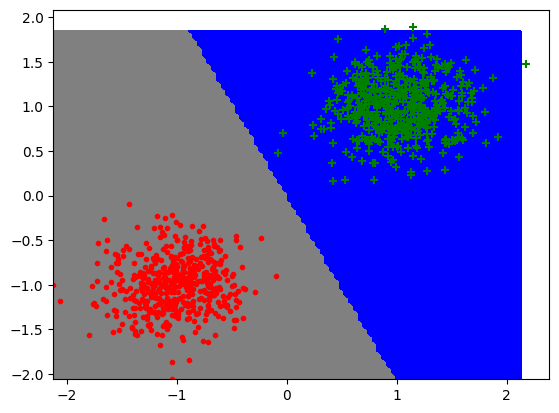

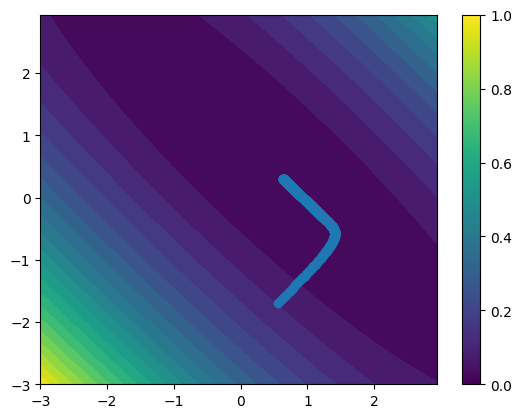

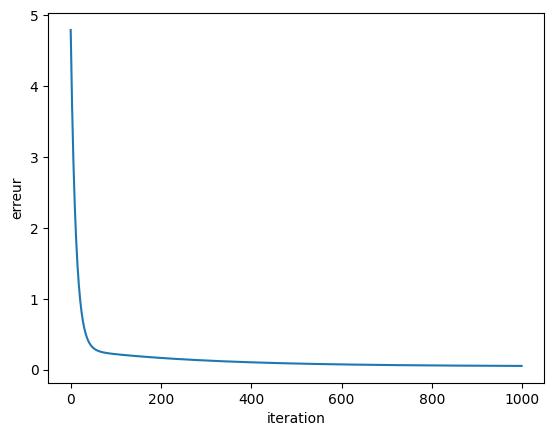

epsilon : 0.01 et nb_itération : 10000


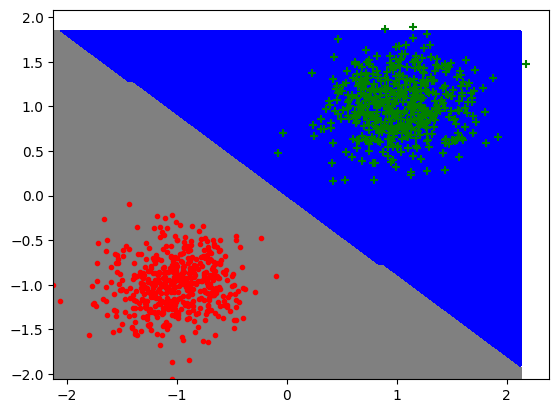

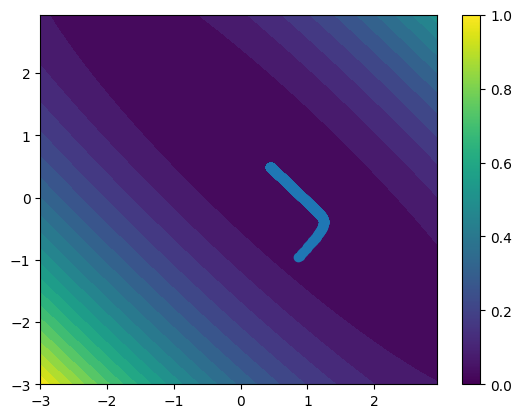

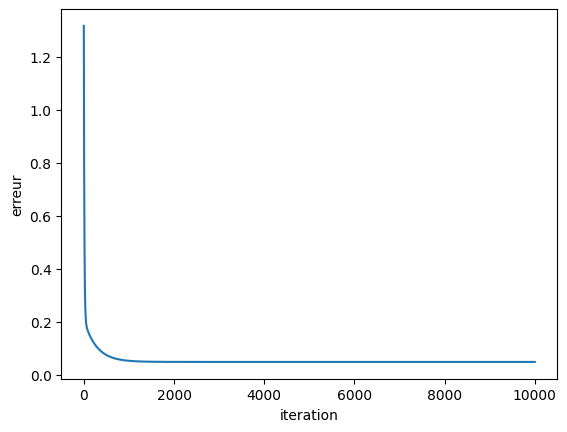

epsilon : 0.1 et nb_itération : 10


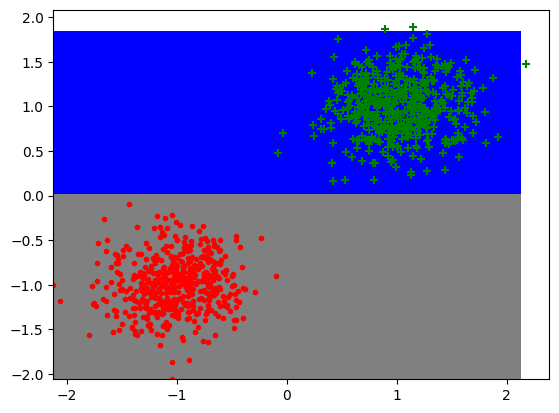

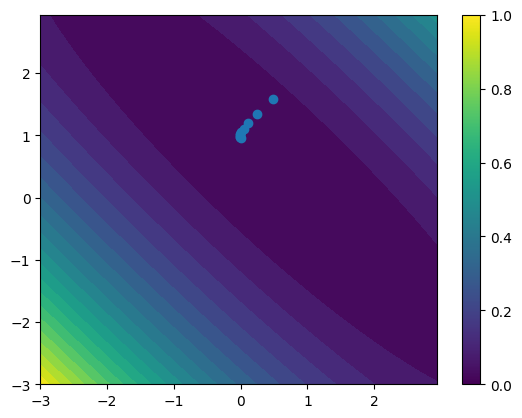

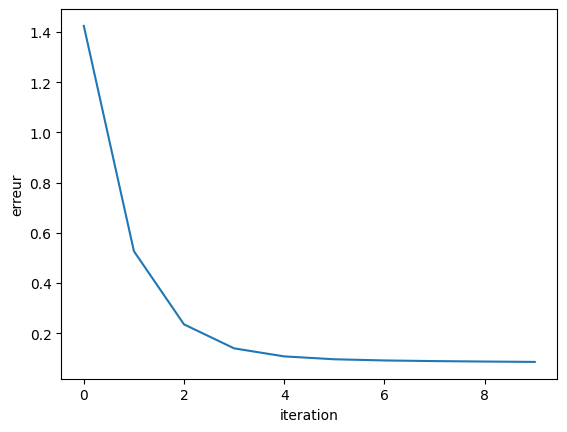

epsilon : 0.1 et nb_itération : 100


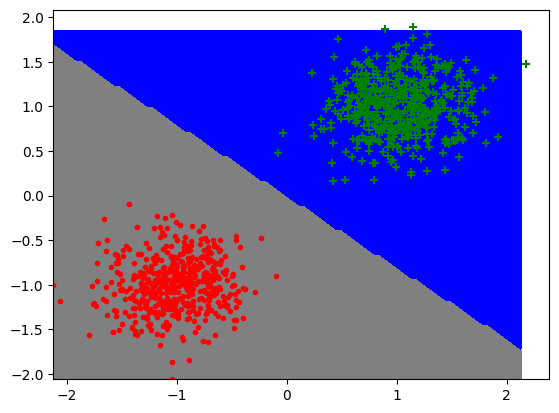

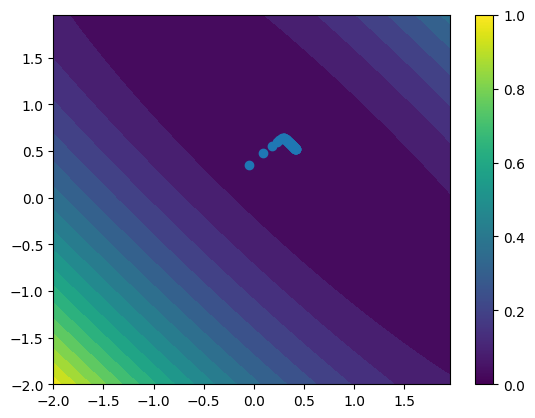

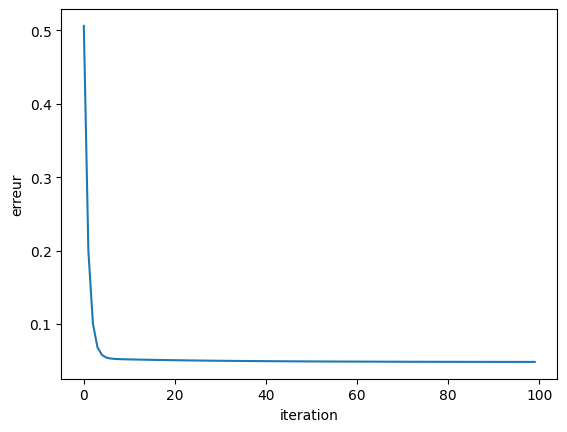

epsilon : 0.1 et nb_itération : 1000


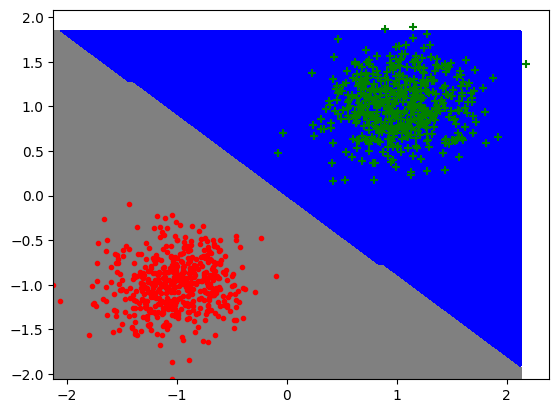

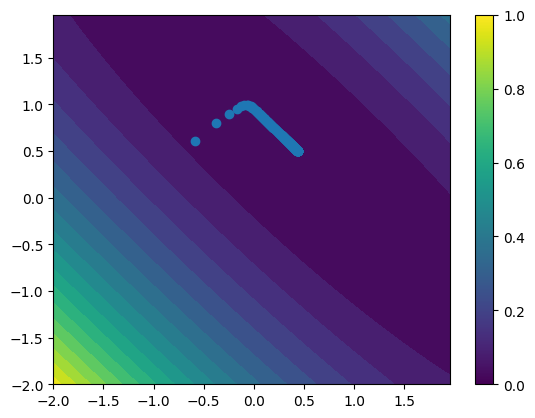

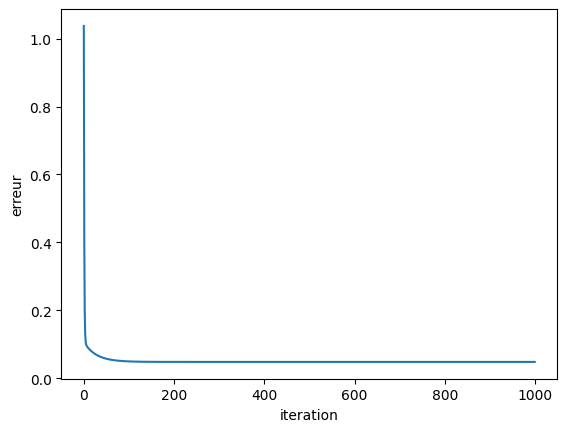

epsilon : 0.1 et nb_itération : 10000


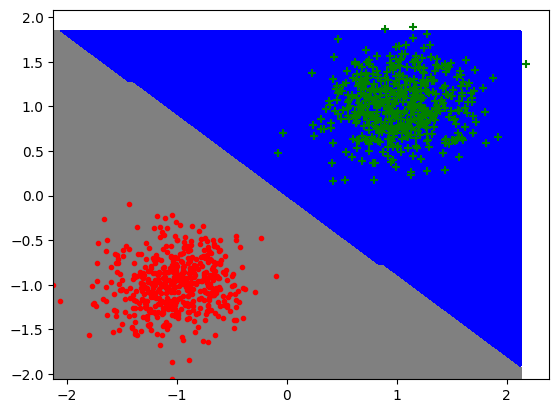

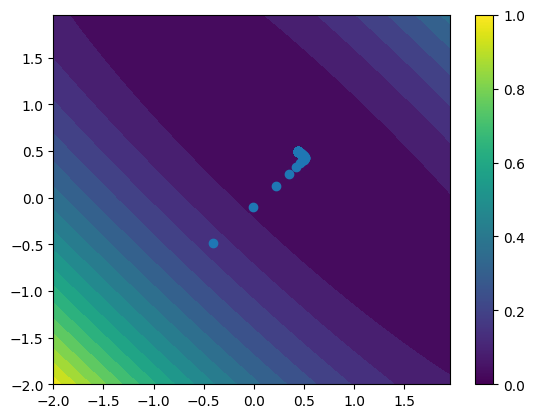

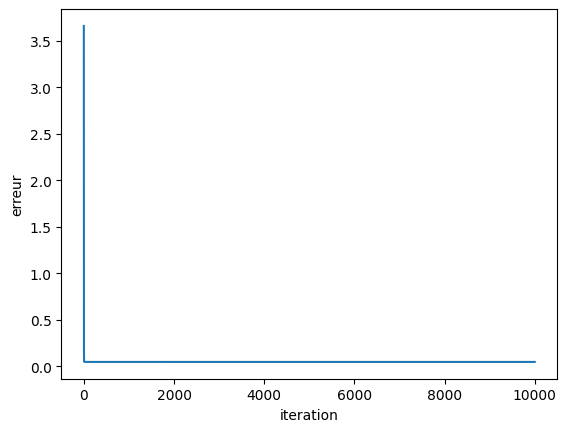

In [4]:
data_type = 0   # int 0-2
epsilon =0.02

## Tirage d'un jeu de données aléatoire bruit faible
datax, datay = gen_arti(epsilon=epsilon)

## Apprentissage
for i in [1e-3,1e-2,1e-1]:
    for j in [10,100,1000,10000]:
        eps=i
        iteration = j
        w, liste_w,liste_error = descente_gradient(datax,datay,mse,mse_grad,eps,iteration)
        print(f'epsilon : {eps} et nb_itération : {iteration}')
        ## Visualisation des données et de la frontière de décision pour un vecteur de poids w
        plt.figure()
        plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
        plot_data(datax,datay)
        ## Visualisation de la fonction de coût en 2D
        ## Fabrication d'une grille de discrétisation pour la visualisation de la fonction de coût
        lim = np.ceil(np.max(np.abs(liste_w))+1)
        grid, x_grid, y_grid = make_grid(xmin=-lim, xmax=lim, ymin=-lim, ymax=lim, step=100)
        plt.figure()
        plt.contourf(x_grid,y_grid,np.array([mse(w,datax,datay).mean() for w in grid]).reshape(x_grid.shape),levels=20)
        plt.scatter(liste_w[:,0],liste_w[:,1])
        plt.colorbar()

        ## Evolution de l'erreur
        plt.figure()
        plt.plot(liste_error)
        plt.xlabel("iteration")
        plt.ylabel("erreur")

        plt.show()
        plt.close()


# Données non bruitées

epsilon : 0.001 et nb_itération : 10


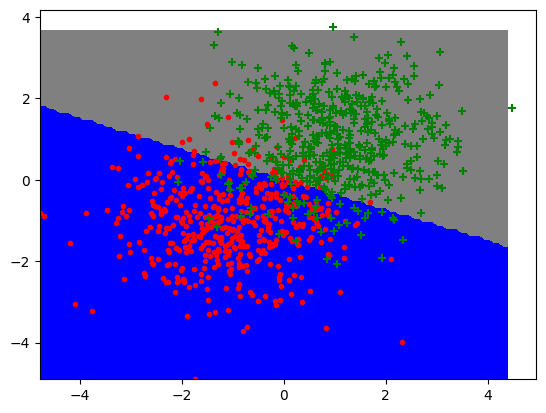

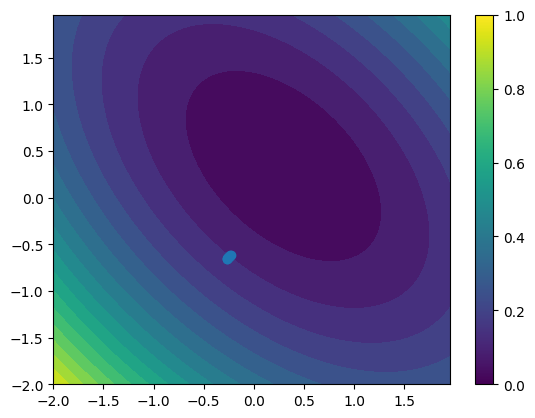

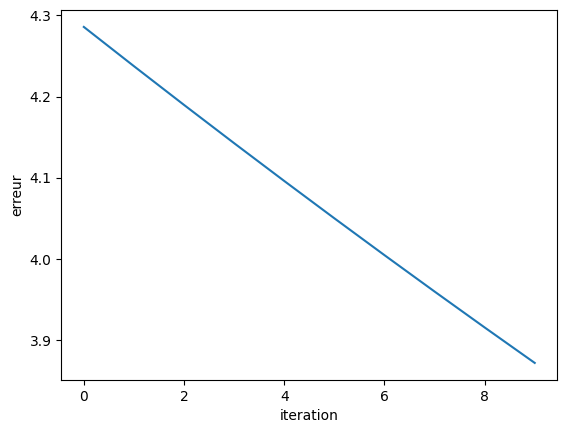

epsilon : 0.001 et nb_itération : 100


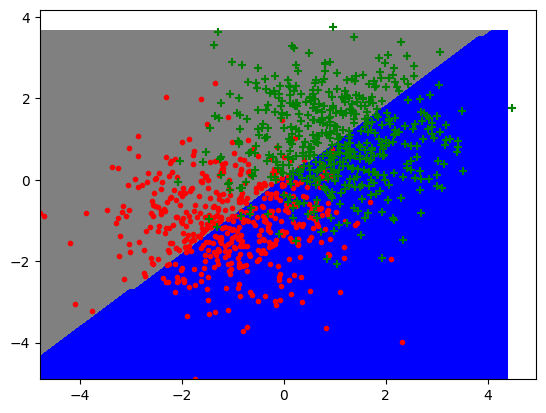

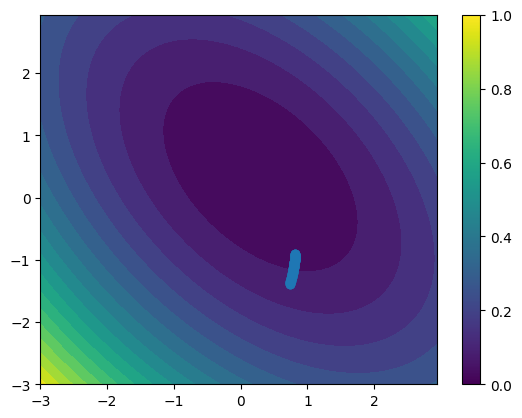

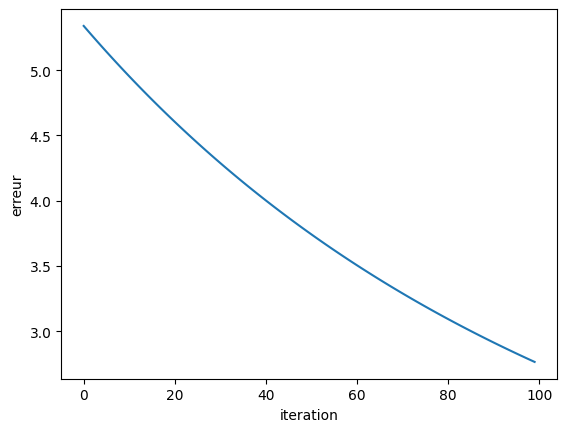

epsilon : 0.001 et nb_itération : 1000


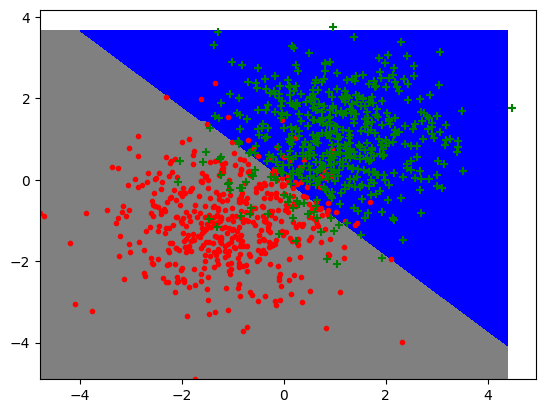

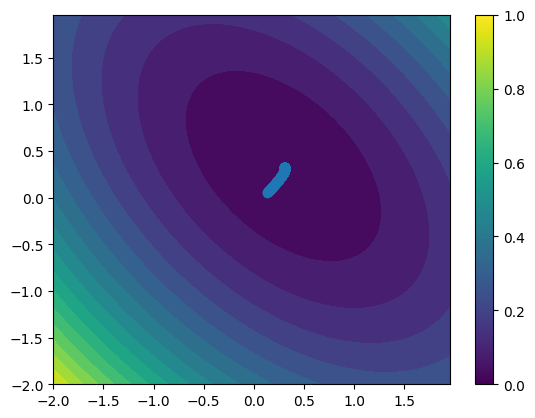

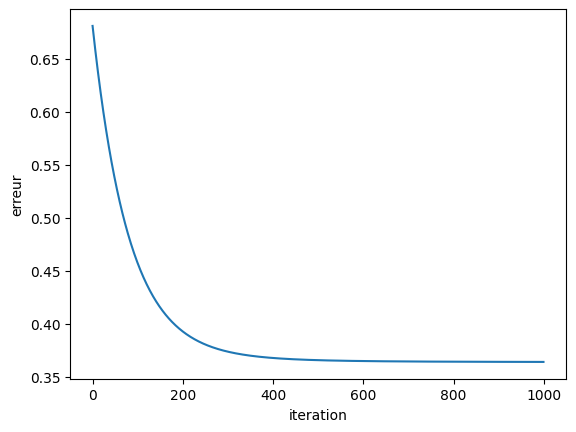

epsilon : 0.001 et nb_itération : 10000


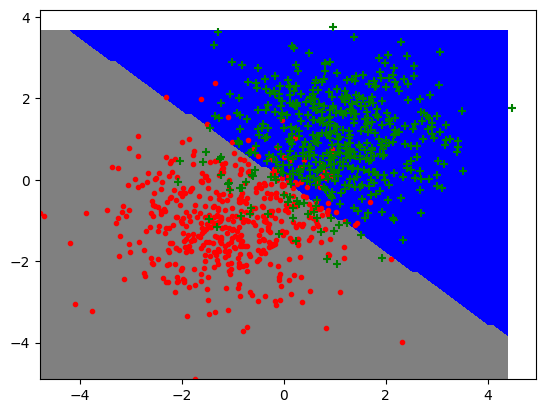

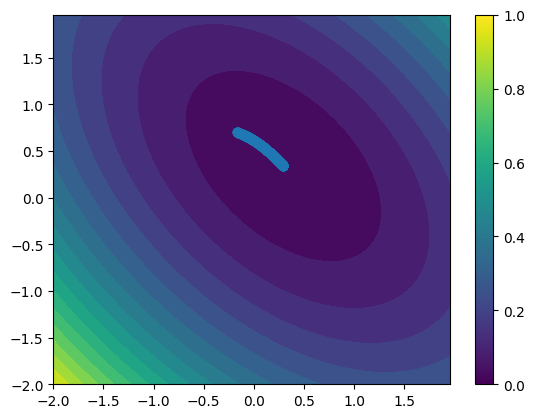

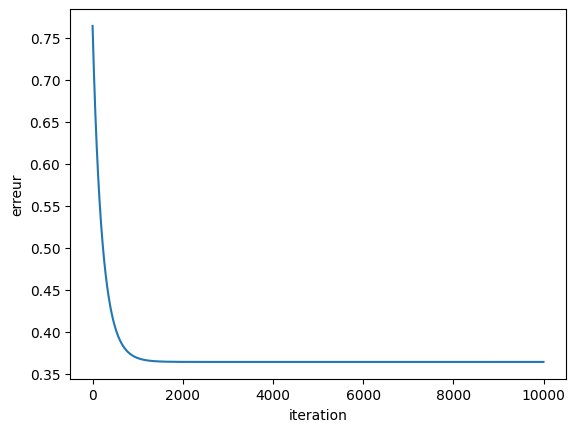

epsilon : 0.01 et nb_itération : 10


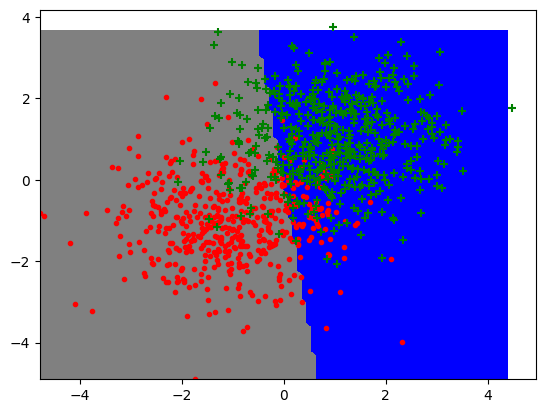

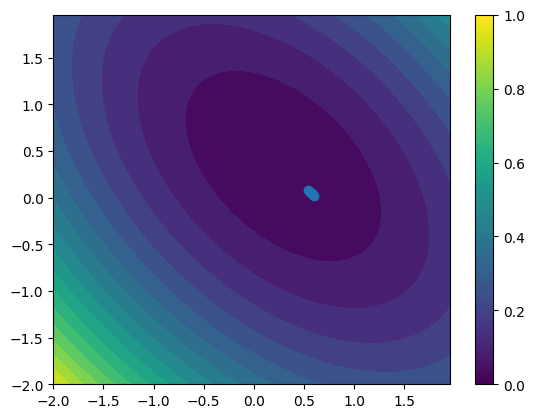

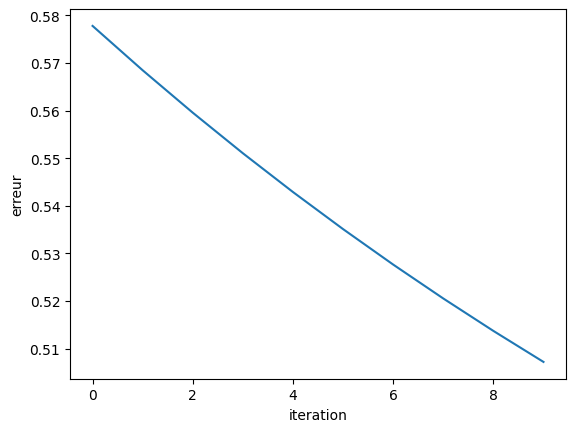

epsilon : 0.01 et nb_itération : 100


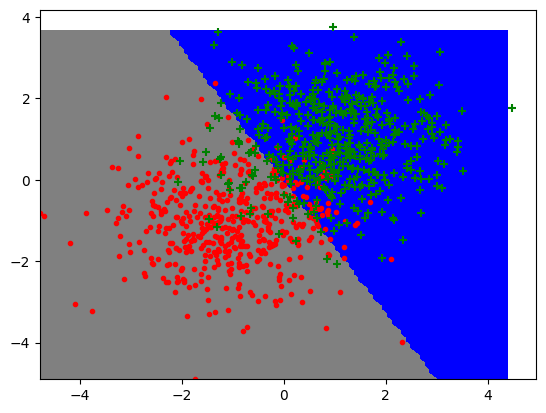

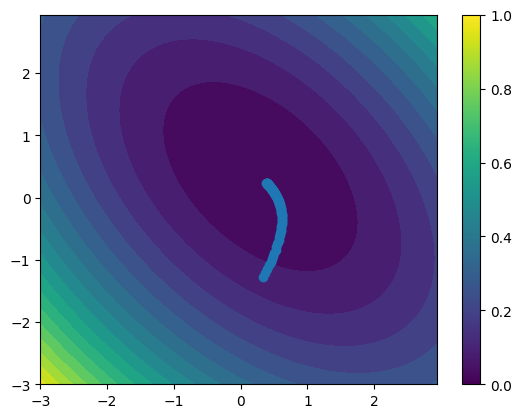

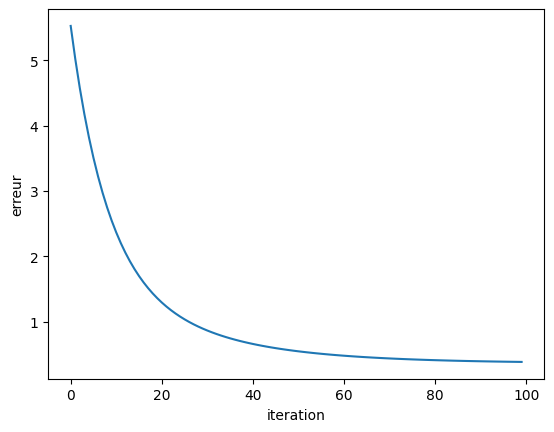

epsilon : 0.01 et nb_itération : 1000


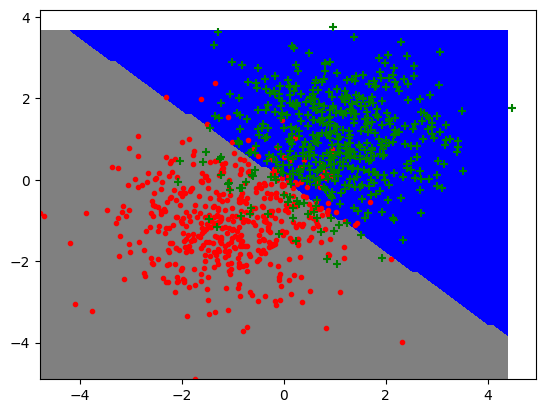

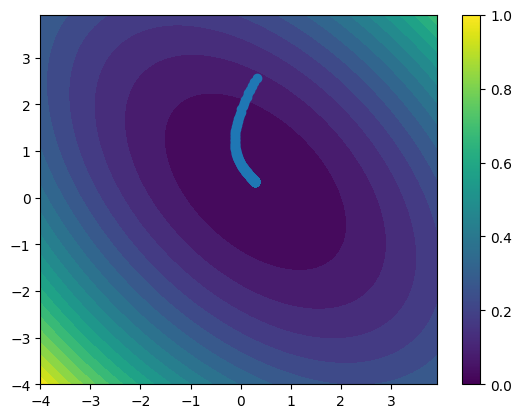

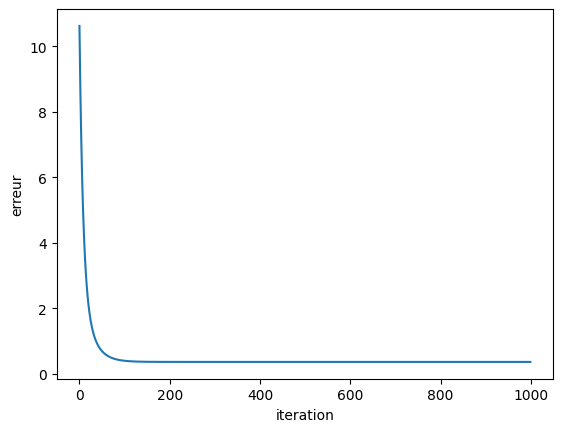

epsilon : 0.01 et nb_itération : 10000


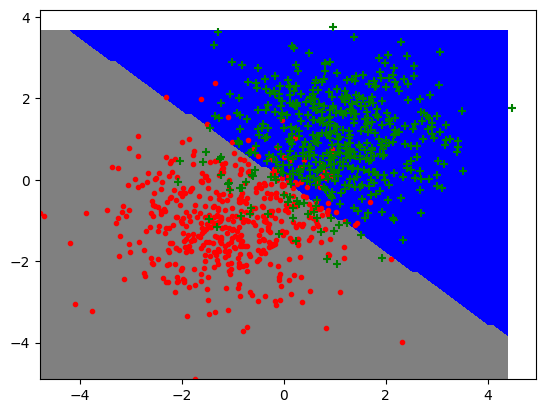

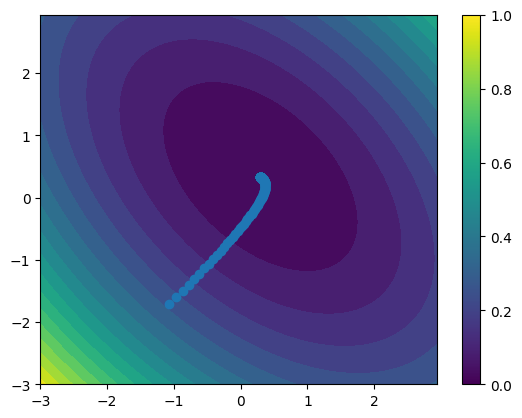

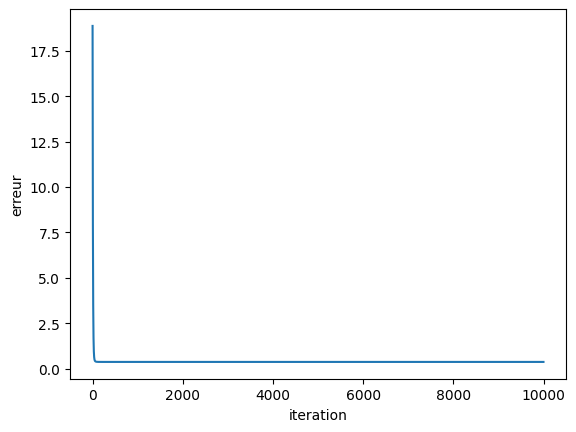

epsilon : 0.1 et nb_itération : 10


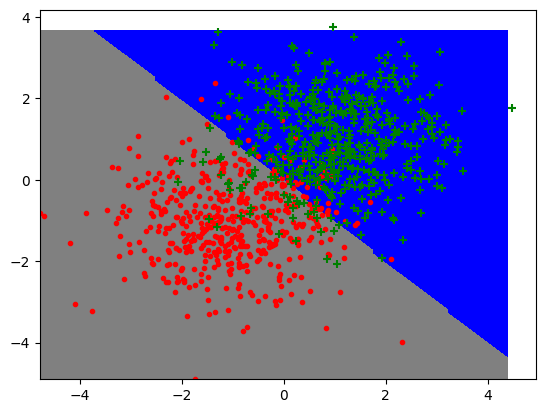

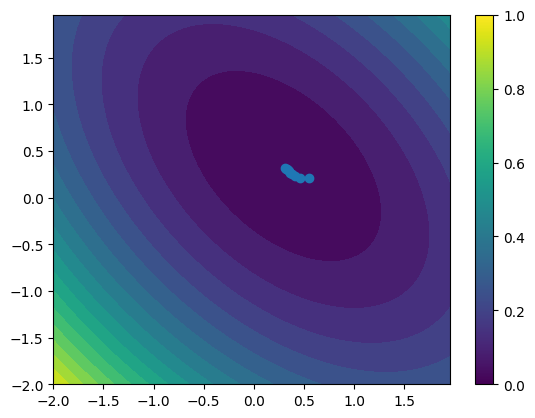

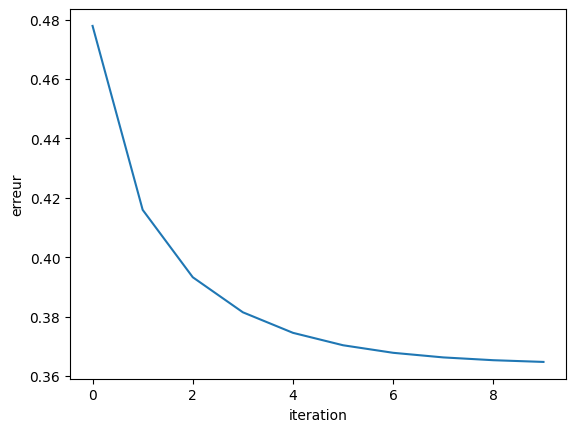

epsilon : 0.1 et nb_itération : 100


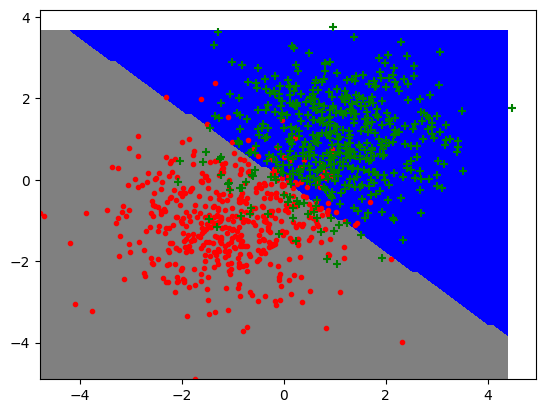

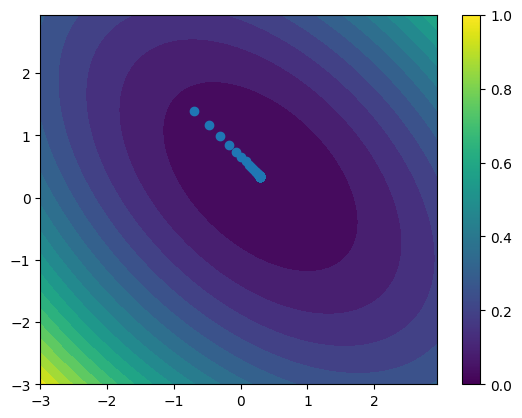

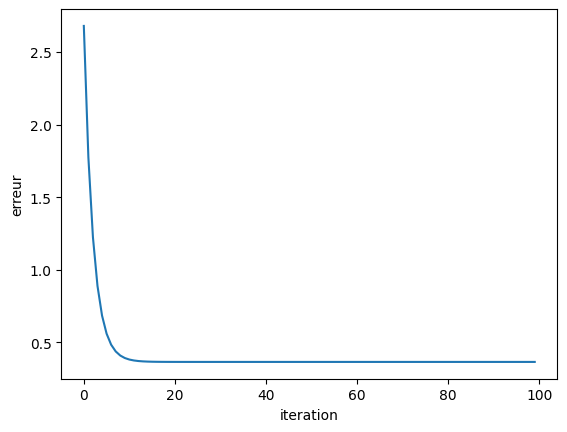

epsilon : 0.1 et nb_itération : 1000


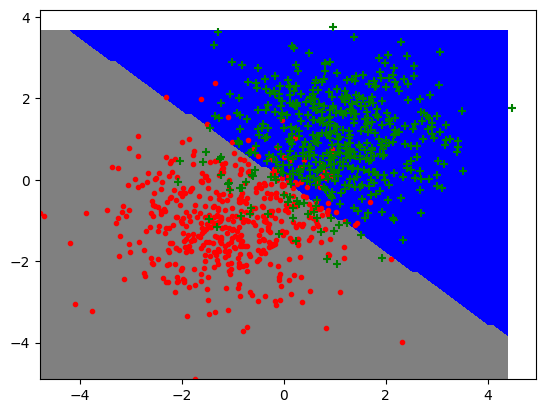

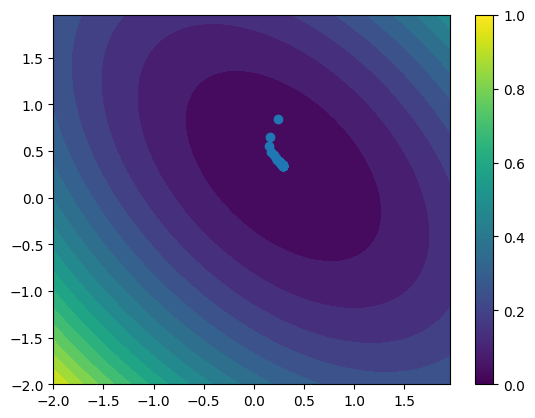

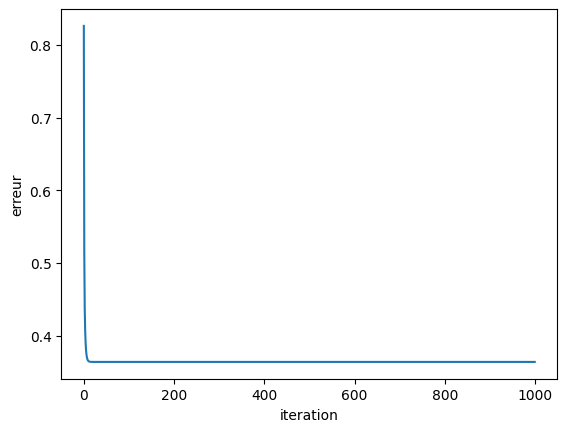

epsilon : 0.1 et nb_itération : 10000


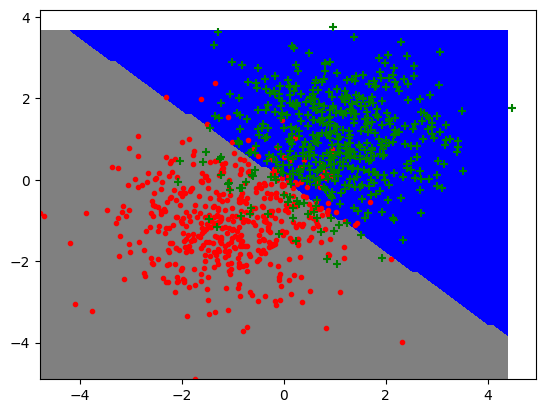

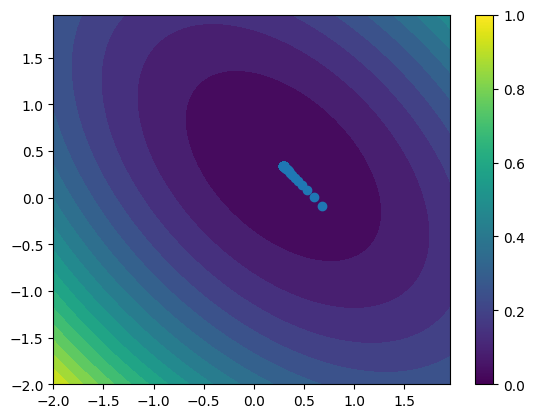

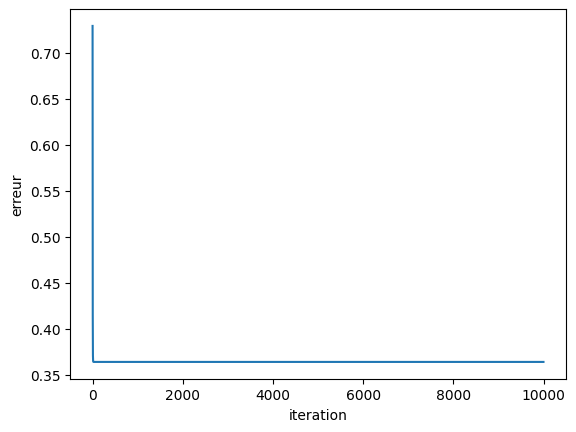

In [5]:
data_type = 0   # int 0-2
epsilon =1

## Tirage d'un jeu de données aléatoire bruit faible
datax, datay = gen_arti(epsilon=epsilon)

## Apprentissage
for i in [1e-3,1e-2,1e-1]:
    for j in [10,100,1000,10000]:
        eps=i
        iteration = j
        w, liste_w,liste_error = descente_gradient(datax,datay,mse,mse_grad,eps,iteration)
        print(f'epsilon : {eps} et nb_itération : {iteration}')
        ## Visualisation des données et de la frontière de décision pour un vecteur de poids w
        plt.figure()
        plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
        plot_data(datax,datay)
        ## Visualisation de la fonction de coût en 2D
        ## Fabrication d'une grille de discrétisation pour la visualisation de la fonction de coût
        lim = np.ceil(np.max(np.abs(liste_w))+1)
        grid, x_grid, y_grid = make_grid(xmin=-lim, xmax=lim, ymin=-lim, ymax=lim, step=100)
        plt.figure()
        plt.contourf(x_grid,y_grid,np.array([mse(w,datax,datay).mean() for w in grid]).reshape(x_grid.shape),levels=20)
        plt.scatter(liste_w[:,0],liste_w[:,1])
        plt.colorbar()

        ## Evolution de l'erreur
        plt.figure()
        plt.plot(liste_error)
        plt.xlabel("iteration")
        plt.ylabel("erreur")

        plt.show()
        plt.close()

# Regression logistique 

# Données non bruitées

epsilon : 0.01 et nb_itération : 100


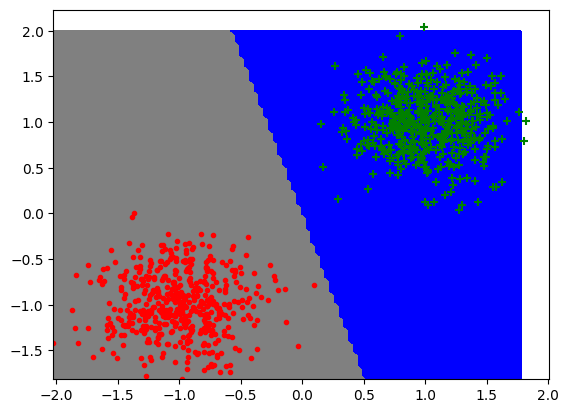

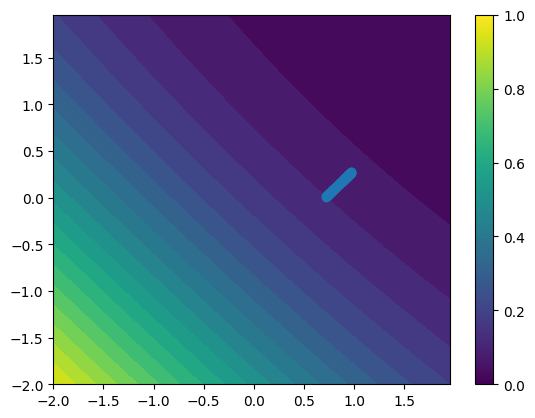

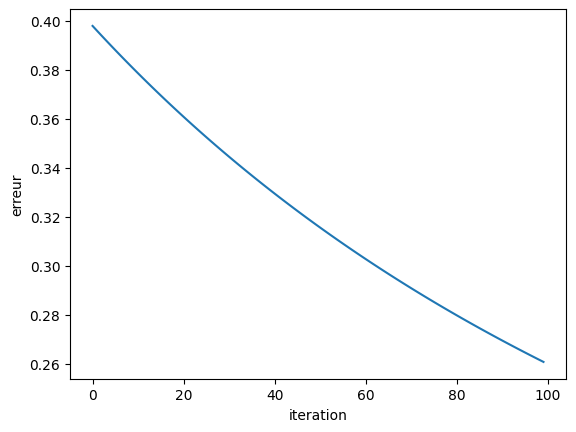

epsilon : 0.01 et nb_itération : 1000


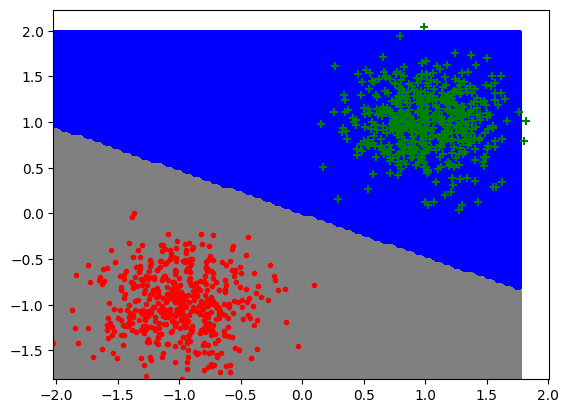

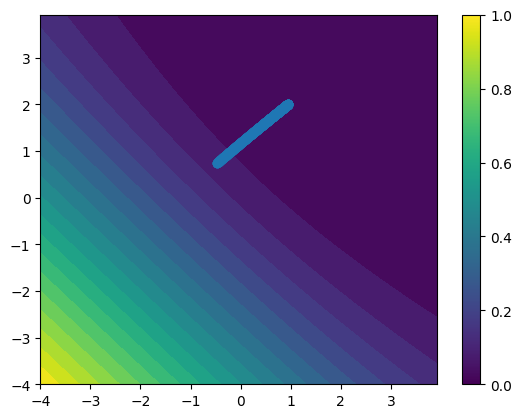

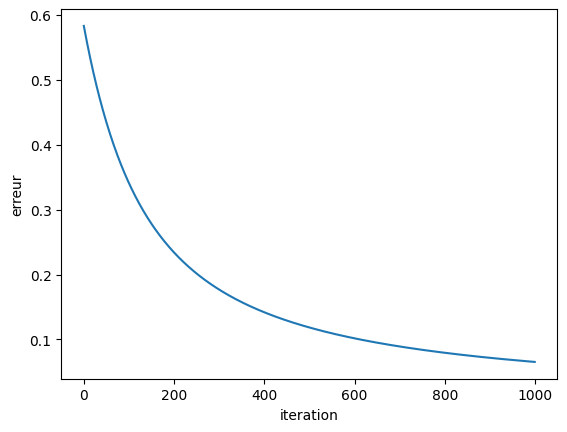

epsilon : 0.01 et nb_itération : 10000


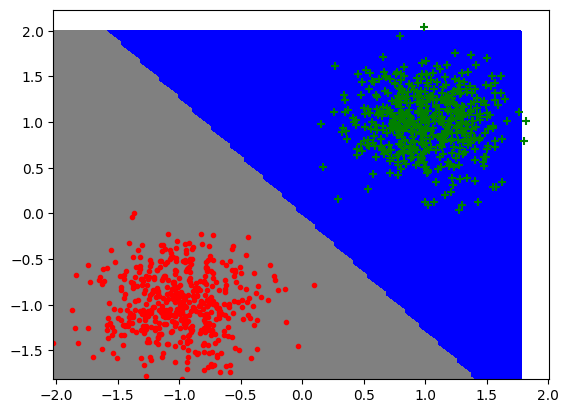

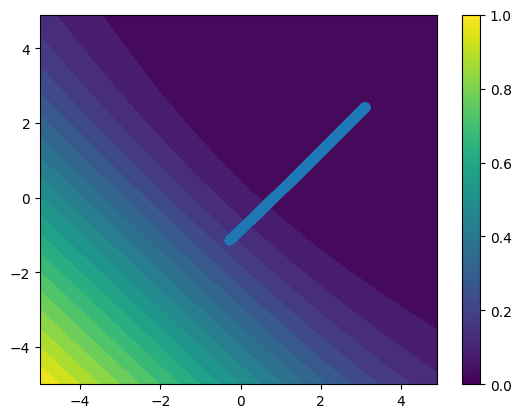

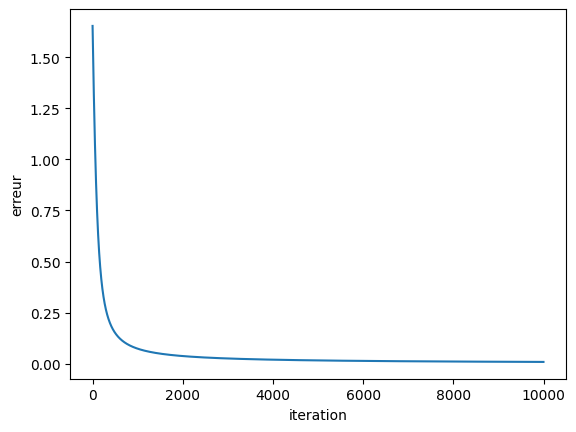

epsilon : 1 et nb_itération : 100


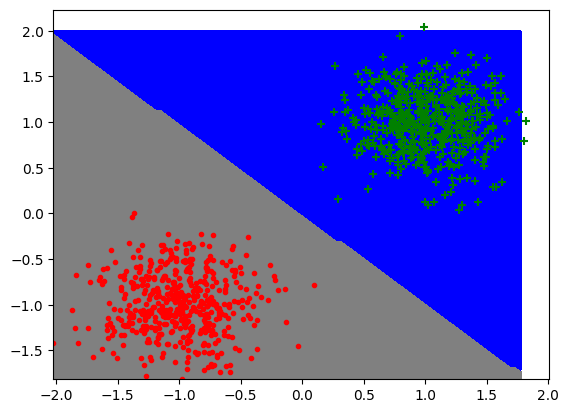

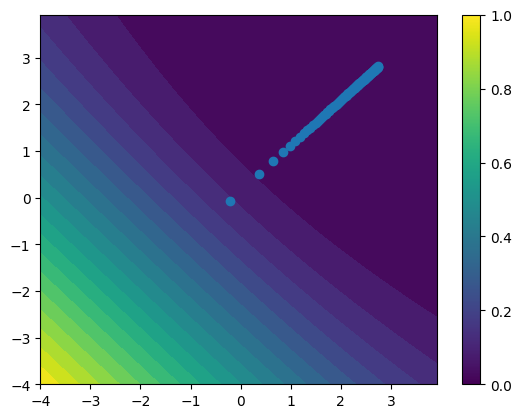

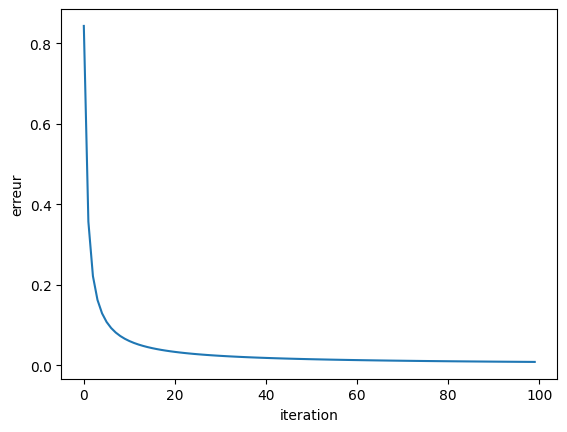

epsilon : 1 et nb_itération : 1000


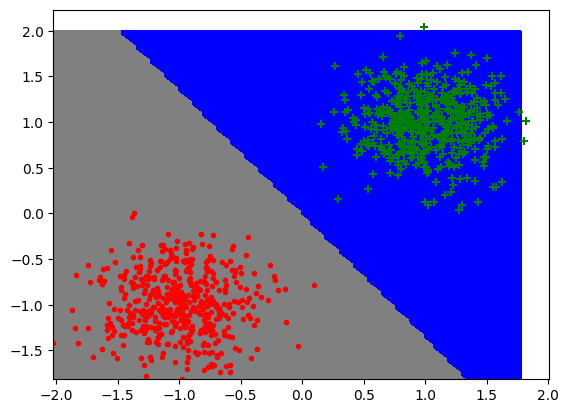

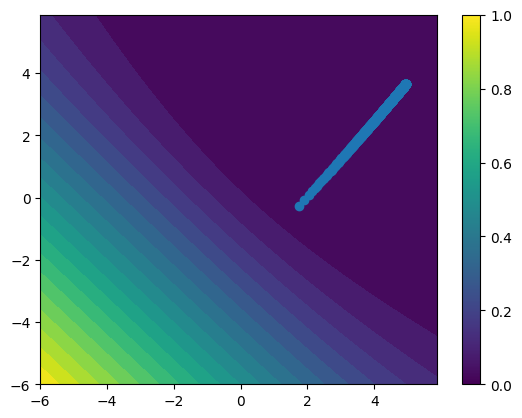

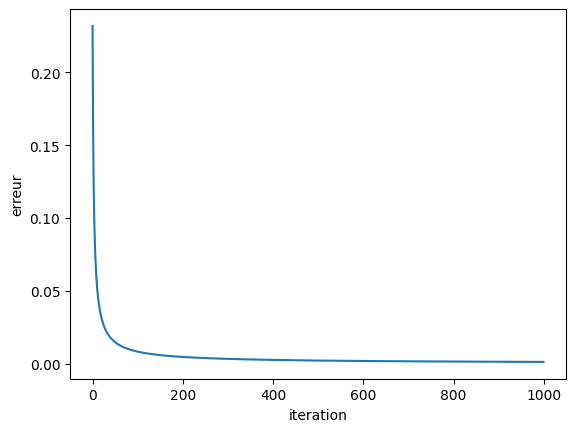

epsilon : 1 et nb_itération : 10000


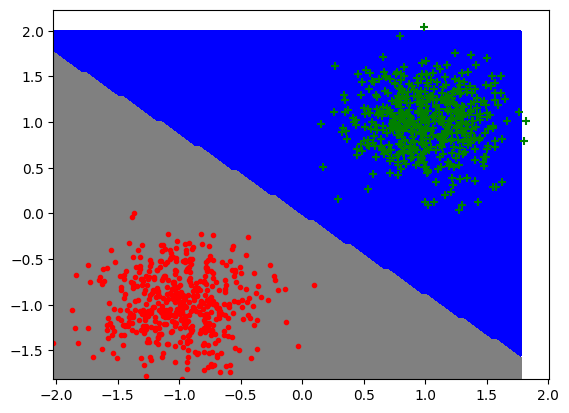

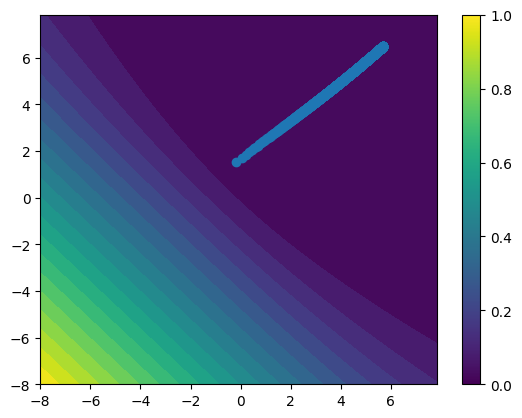

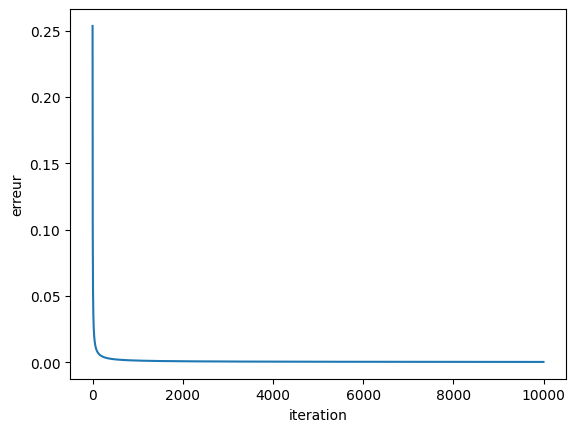

epsilon : 100 et nb_itération : 100


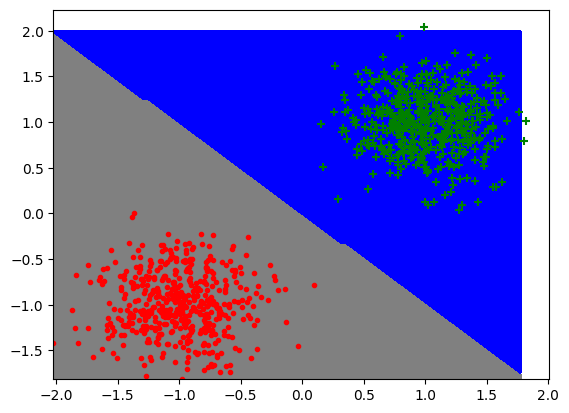

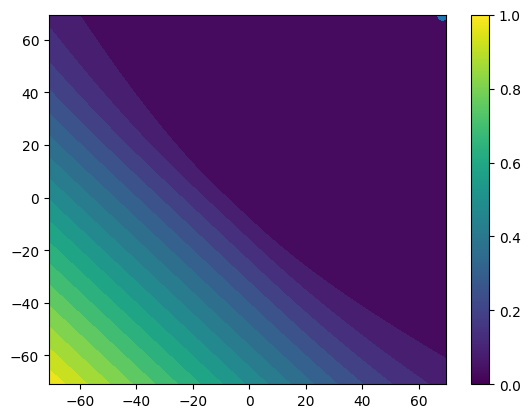

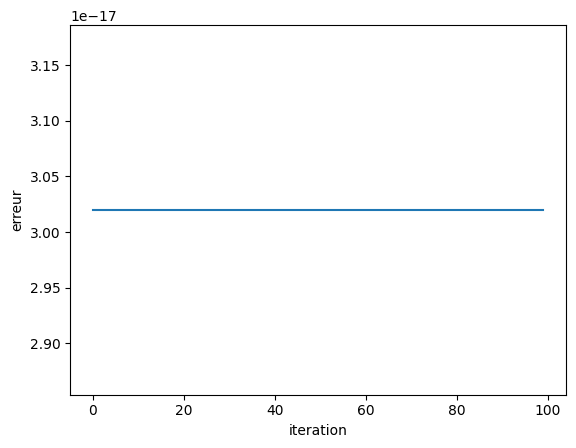

epsilon : 100 et nb_itération : 1000


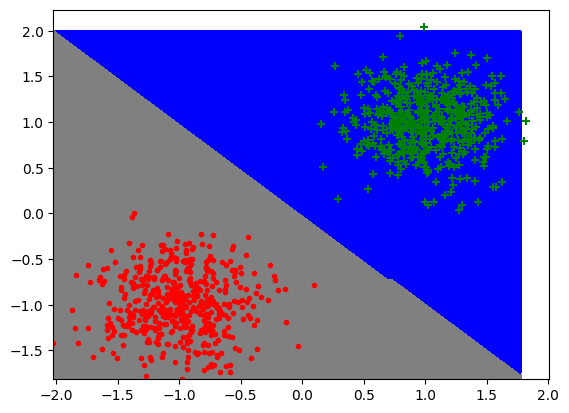

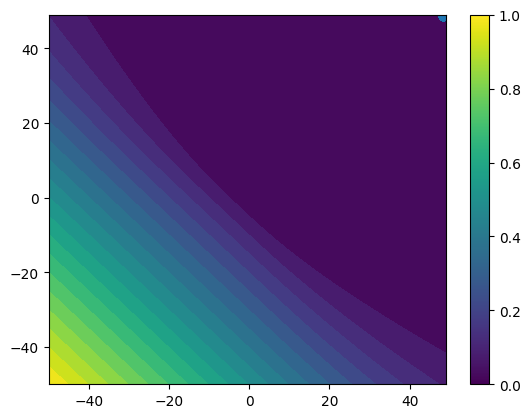

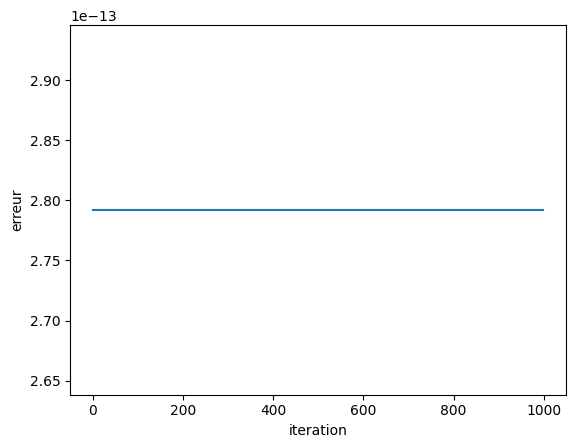

epsilon : 100 et nb_itération : 10000


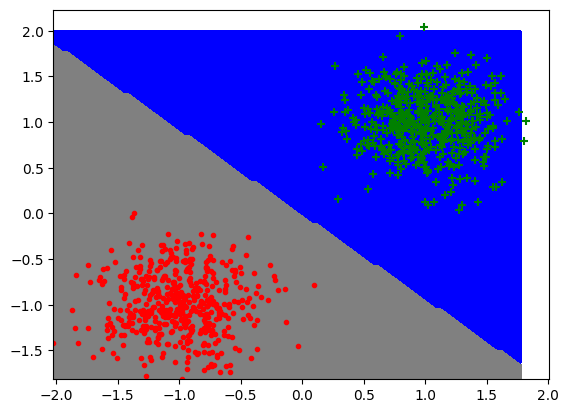

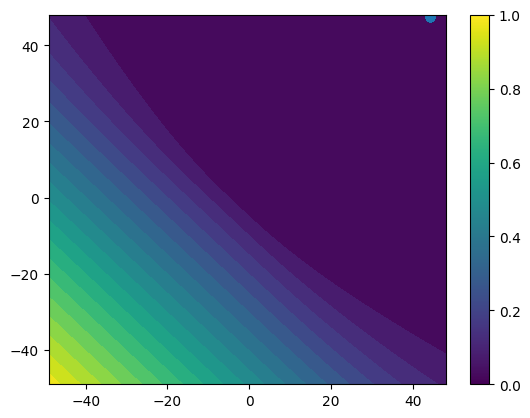

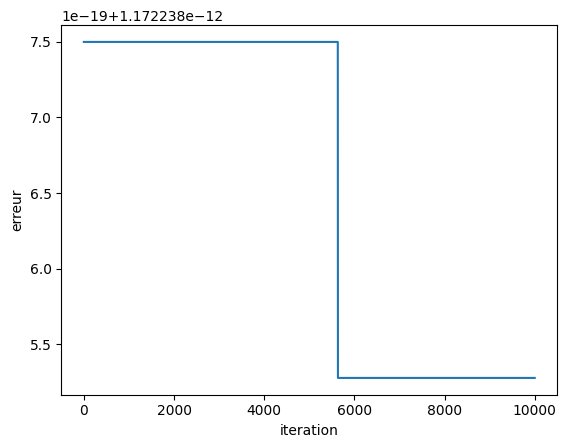

In [6]:
data_type = 0   # int 0-2
epsilon =0.02   # regler bruit

## Tirage d'un jeu de données aléatoire bruit faible
datax, datay = gen_arti(epsilon=epsilon)

## Apprentissage
for i in [1e-2,1,100]:
    for j in [100,1000,10000]:
        eps= i             # regler le pas
        iteration = j    # regler iteration
        w, liste_w,liste_error = descente_gradient(datax,datay,reglog,reglog_grad,eps,iteration)
        print(f'epsilon : {eps} et nb_itération : {iteration}')
        ## Visualisation des données et de la frontière de décision pour un vecteur de poids w
        plt.figure()
        plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
        plot_data(datax,datay)


        ## Visualisation de la fonction de coût en 2D
        ## Fabrication d'une grille de discrétisation pour la visualisation de la fonction de coût
        lim = np.ceil(np.max(np.abs(liste_w))+1)
        grid, x_grid, y_grid = make_grid(xmin=-lim, xmax=lim, ymin=-lim, ymax=lim, step=100)
        plt.figure()
        plt.contourf(x_grid,y_grid,np.array([reglog(w,datax,datay).mean() for w in grid]).reshape(x_grid.shape),levels=20)
        plt.scatter(liste_w[:,0],liste_w[:,1])
        plt.colorbar()

        ## Evolution de l'erreur
        plt.figure()
        plt.plot(liste_error)
        plt.xlabel("iteration")
        plt.ylabel("erreur")
        plt.show()
        plt.close

# Données bruitées

epsilon : 0.01 et nb_itération : 100


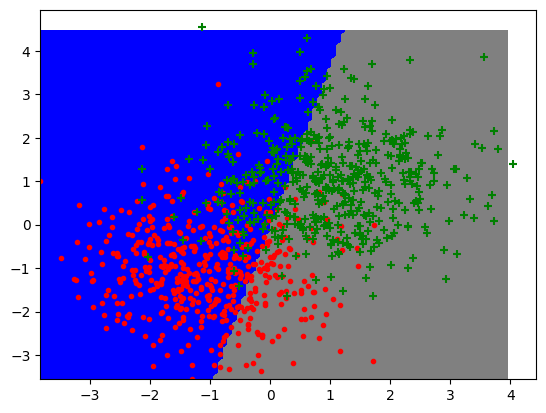

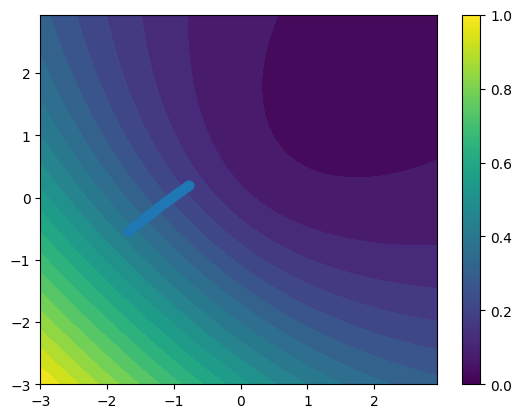

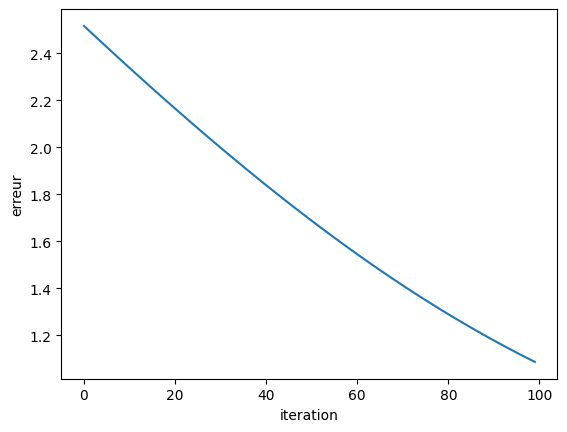

epsilon : 0.01 et nb_itération : 1000


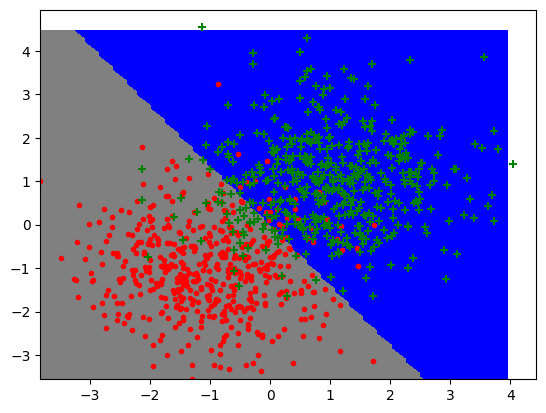

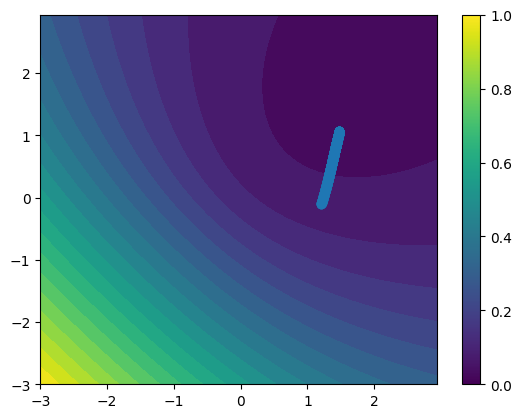

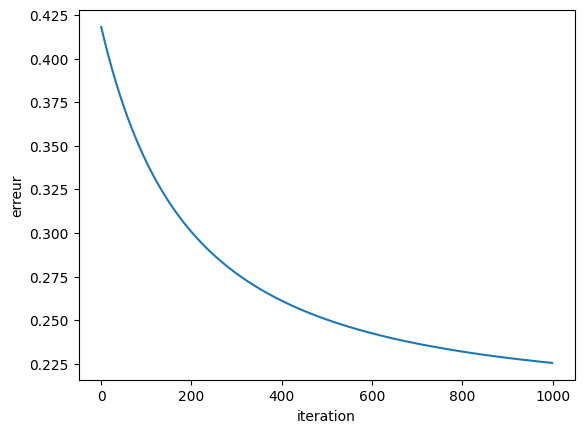

epsilon : 0.01 et nb_itération : 10000


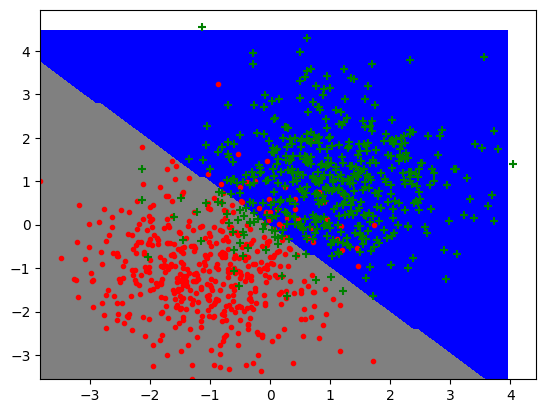

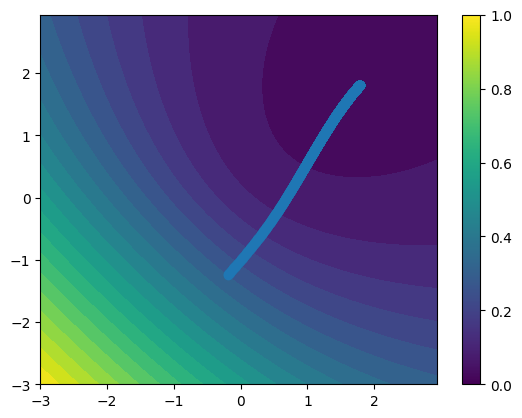

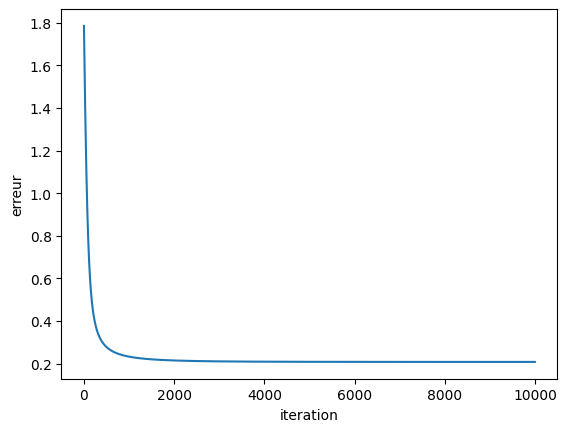

epsilon : 1 et nb_itération : 100


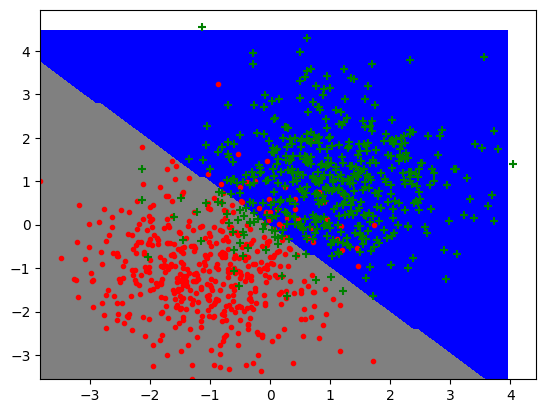

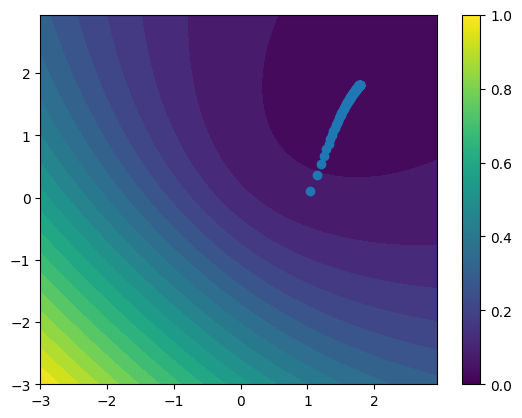

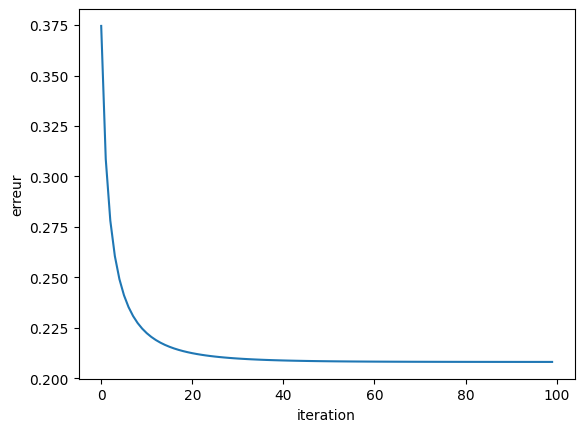

epsilon : 1 et nb_itération : 1000


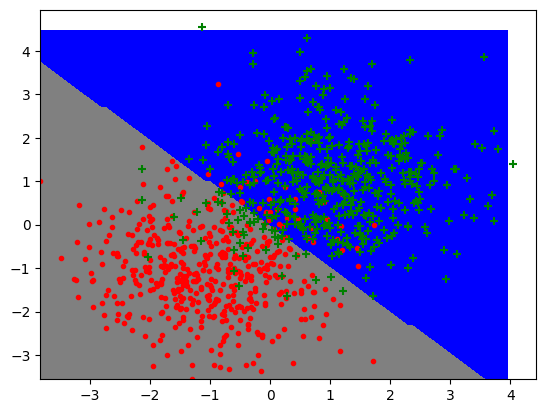

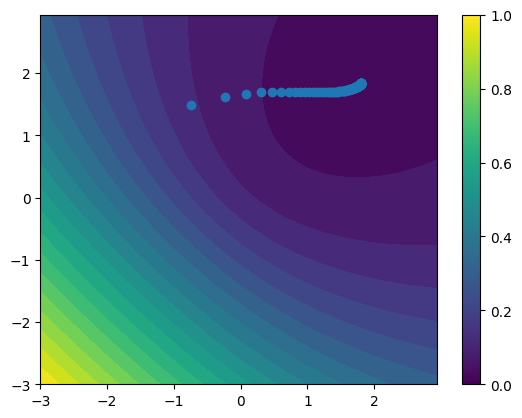

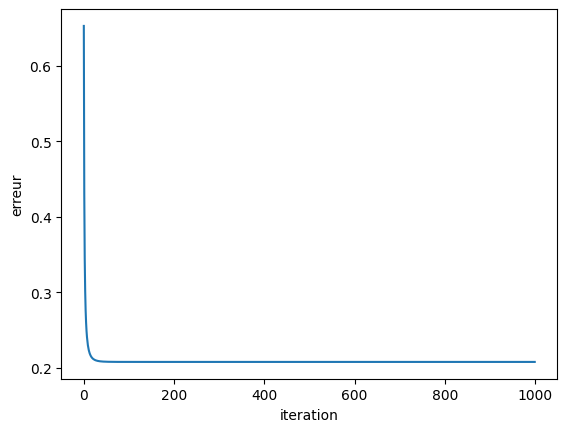

epsilon : 1 et nb_itération : 10000


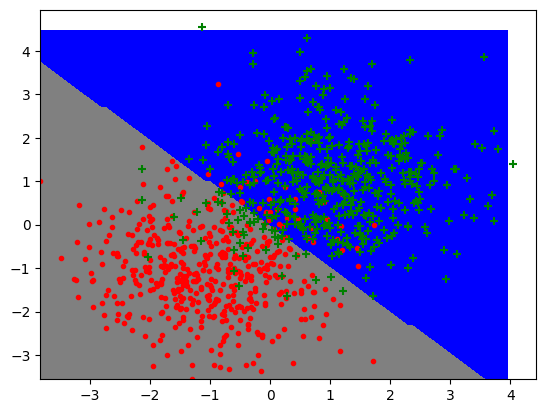

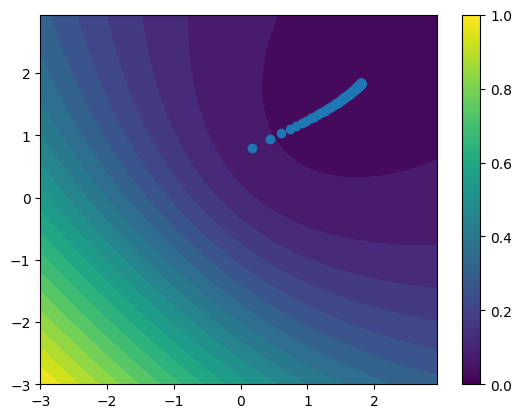

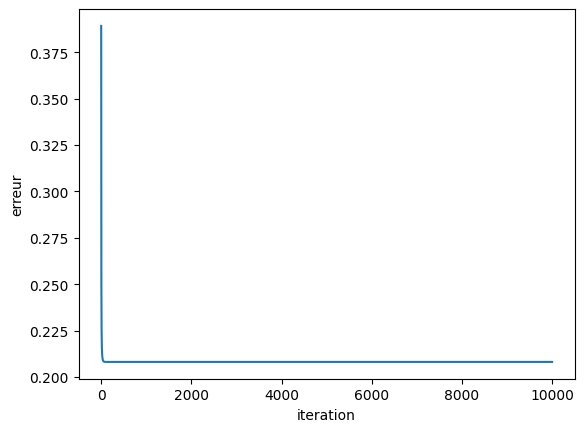

epsilon : 100 et nb_itération : 100


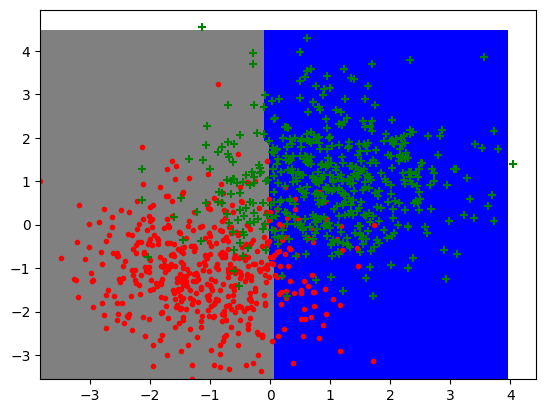

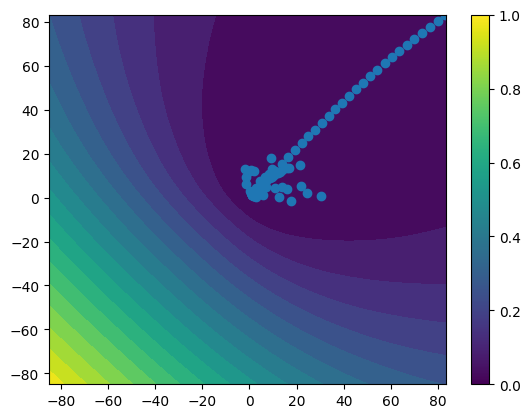

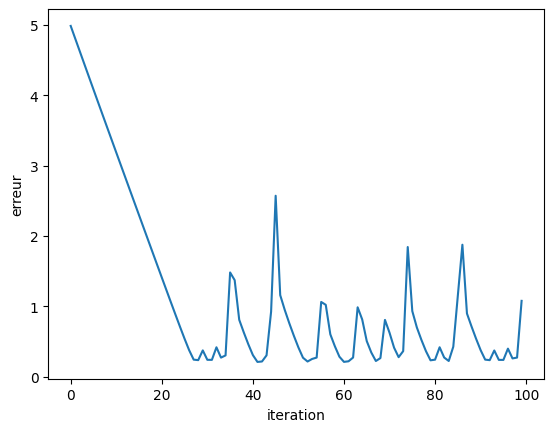

epsilon : 100 et nb_itération : 1000


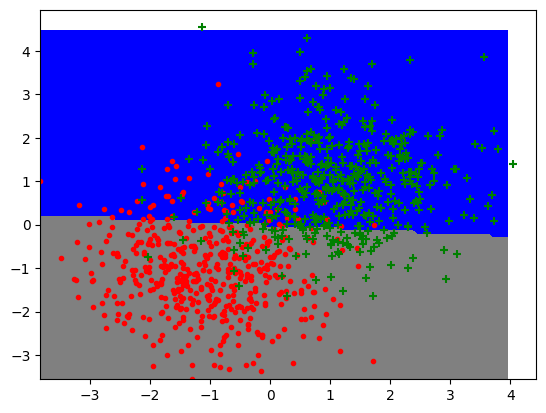

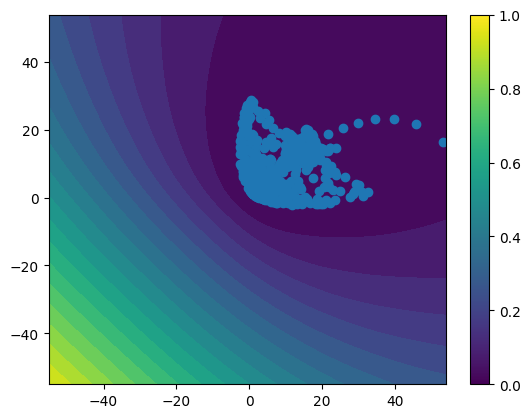

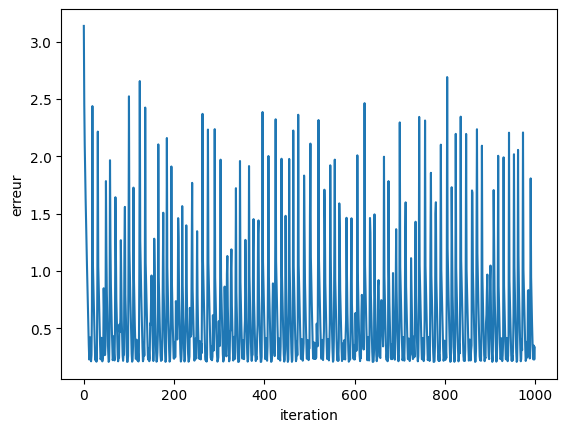

epsilon : 100 et nb_itération : 10000


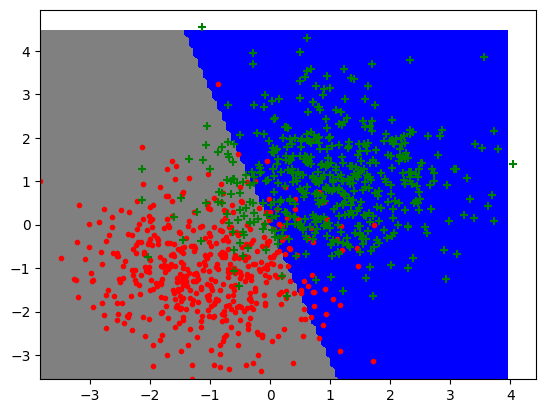

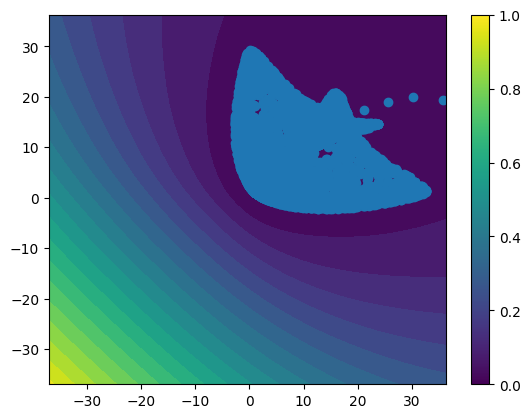

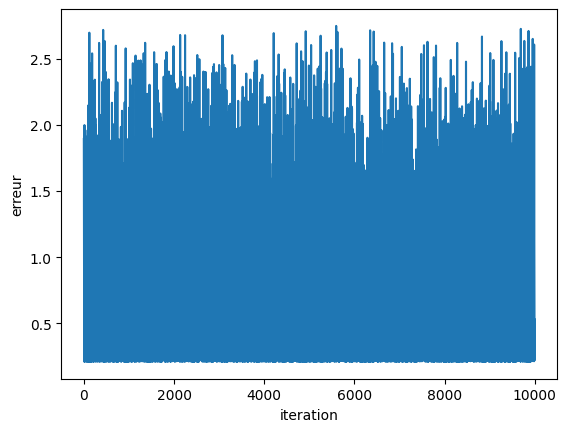

In [7]:
data_type = 0   # int 0-2
epsilon =1   # regler bruit

## Tirage d'un jeu de données aléatoire bruit faible
datax, datay = gen_arti(epsilon=epsilon)

## Apprentissage
for i in [1e-2,1,100]:
    for j in [100,1000,10000]:
        eps= i             # regler le pas
        iteration = j    # regler iteration
        w, liste_w,liste_error = descente_gradient(datax,datay,reglog,reglog_grad,eps,iteration)
        print(f'epsilon : {eps} et nb_itération : {iteration}')
        ## Visualisation des données et de la frontière de décision pour un vecteur de poids w
        plt.figure()
        plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
        plot_data(datax,datay)


        ## Visualisation de la fonction de coût en 2D
        ## Fabrication d'une grille de discrétisation pour la visualisation de la fonction de coût
        lim = np.ceil(np.max(np.abs(liste_w))+1)
        grid, x_grid, y_grid = make_grid(xmin=-lim, xmax=lim, ymin=-lim, ymax=lim, step=100)
        plt.figure()
        plt.contourf(x_grid,y_grid,np.array([reglog(w,datax,datay).mean() for w in grid]).reshape(x_grid.shape),levels=20)
        plt.scatter(liste_w[:,0],liste_w[:,1])
        plt.colorbar()

        ## Evolution de l'erreur
        plt.figure()
        plt.plot(liste_error)
        plt.xlabel("iteration")
        plt.ylabel("erreur")
        plt.show()
        plt.close

# Que se passe-t-il quand on modifie les parametres ? 

Si epsilon trop petit le risque est de mettre enormement de temps avant de converger

Si epsilon grand le risque est de diverger 

Si le nombre d'iteration est trop faible le risque est de ne pas converger par manque d'iteration

Si le nombre d'itération est trop grand le risque est de converger mais de continuer à faire des itérations pour rien 

# Différence entre des données bruitées et non bruitées

Lorsque l'on augmente le bruit, on visualise bien en 2D que les données ne forme plus deux groupes distincts.
Dans ce cas, la frontière de décision si situe à l'endroit ou l'on minimise le cout , il va exister des données effectivement mal classées

# Données echiquier

epsilon : 0.01 et nb_itération : 100


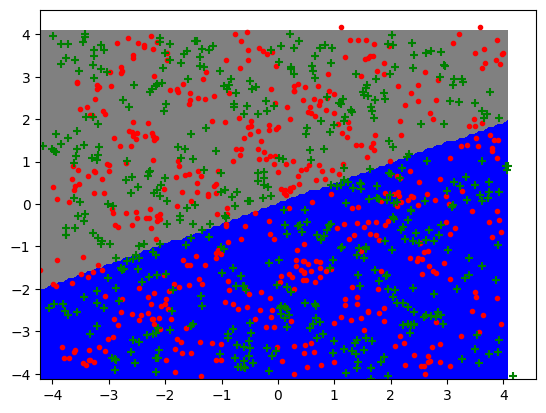

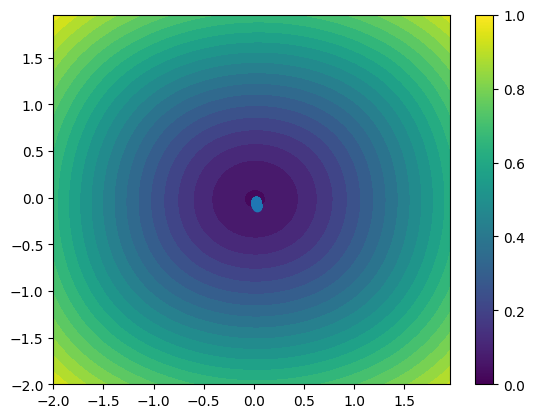

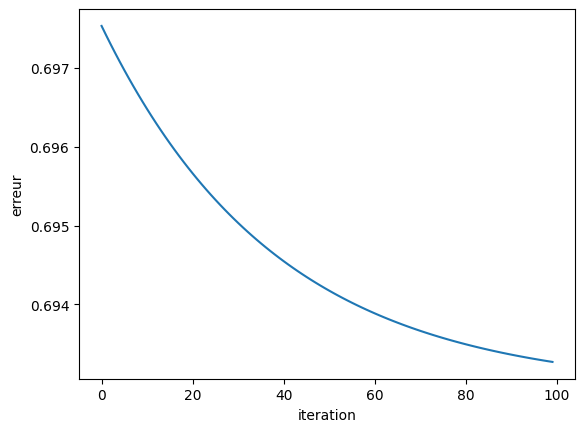

epsilon : 0.01 et nb_itération : 1000


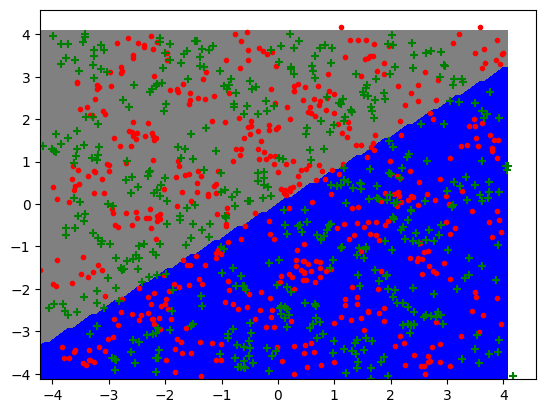

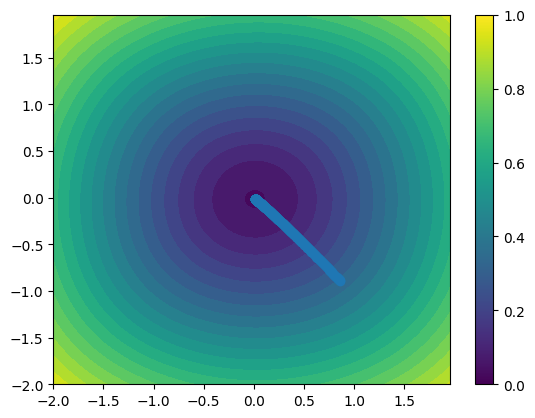

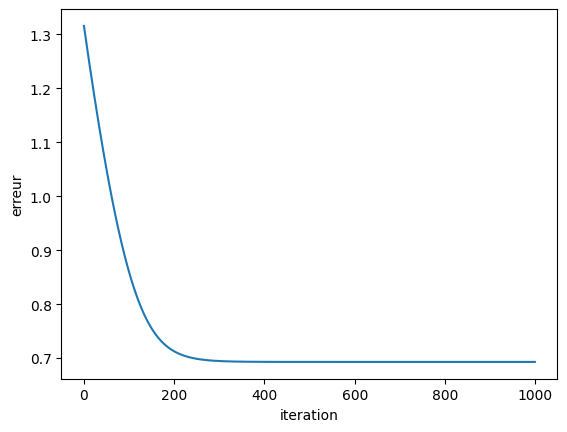

epsilon : 0.01 et nb_itération : 10000


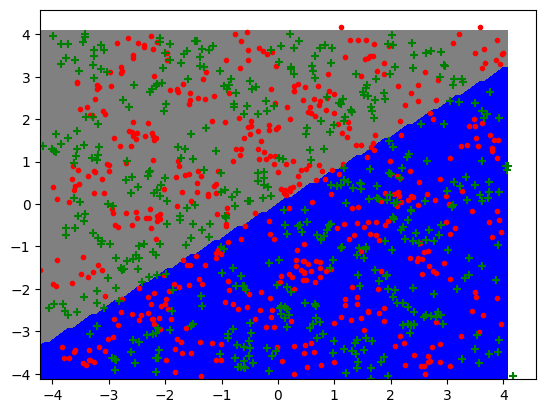

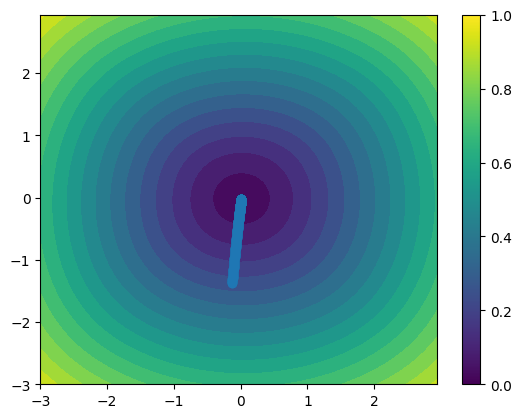

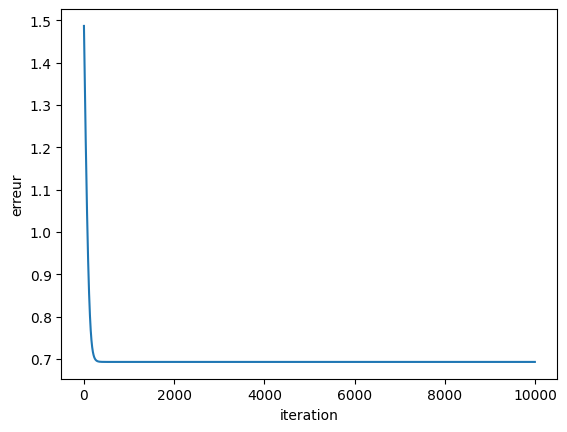

epsilon : 1 et nb_itération : 100


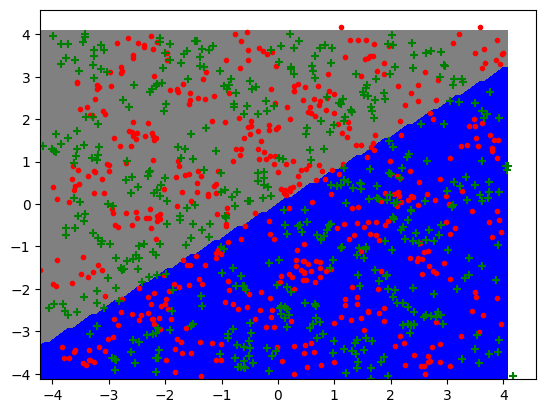

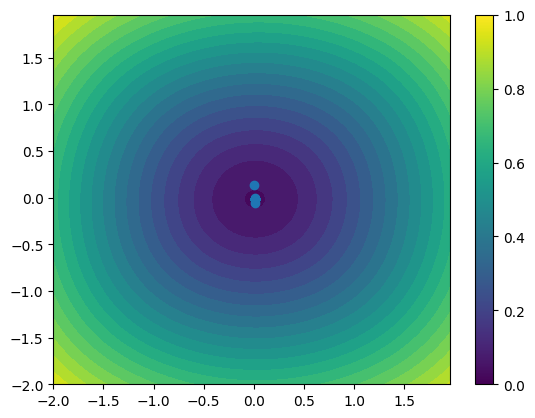

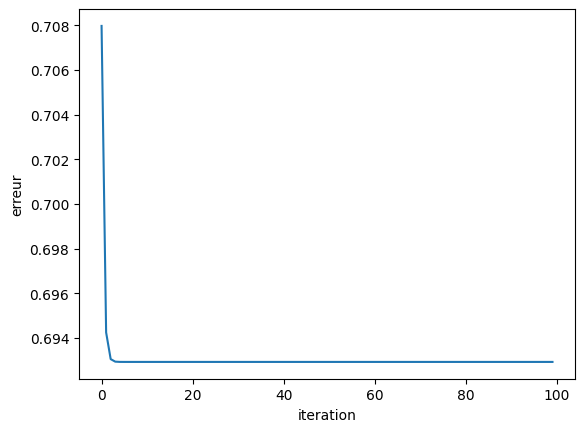

epsilon : 1 et nb_itération : 1000


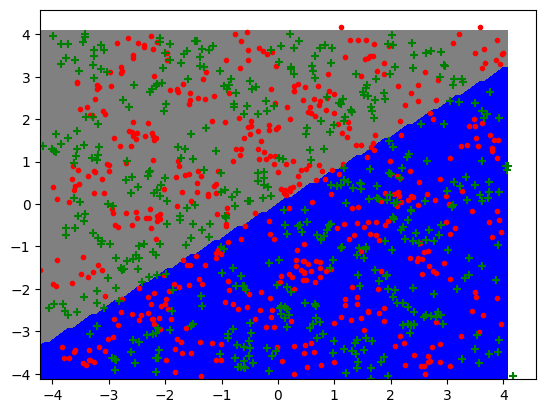

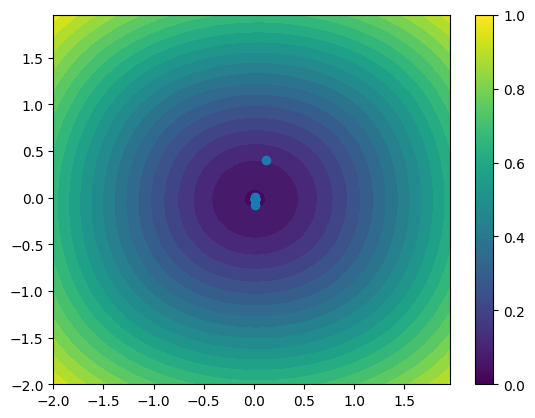

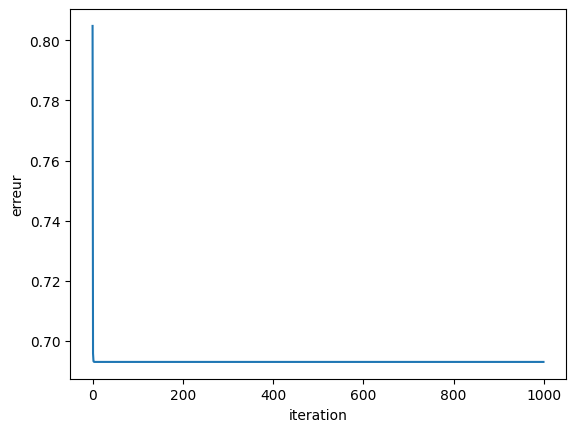

epsilon : 1 et nb_itération : 10000


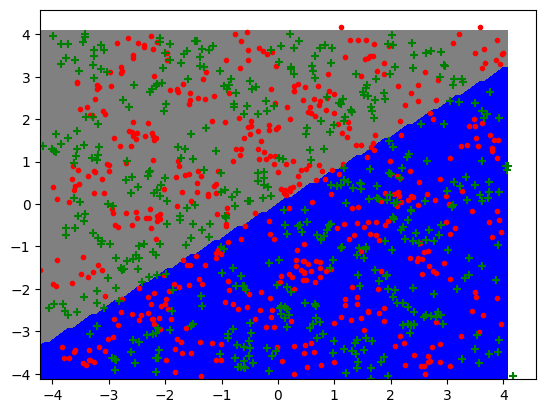

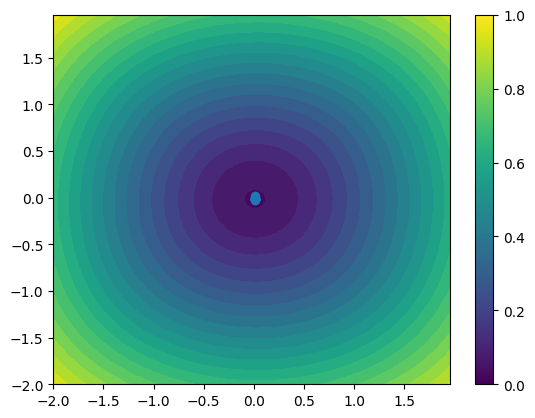

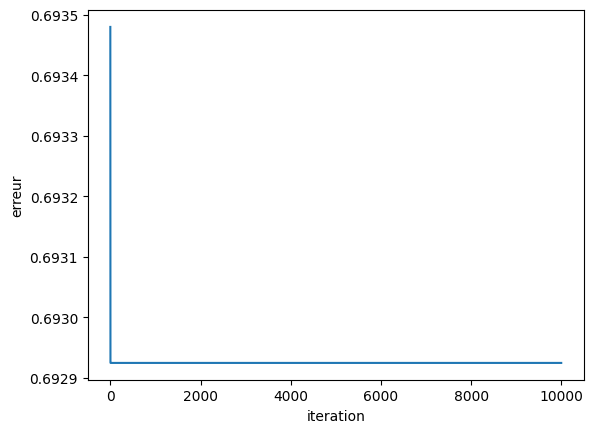

epsilon : 100 et nb_itération : 100


/tmp/ipykernel_37144/4055388464.py:24: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(-(y*(x@w))))


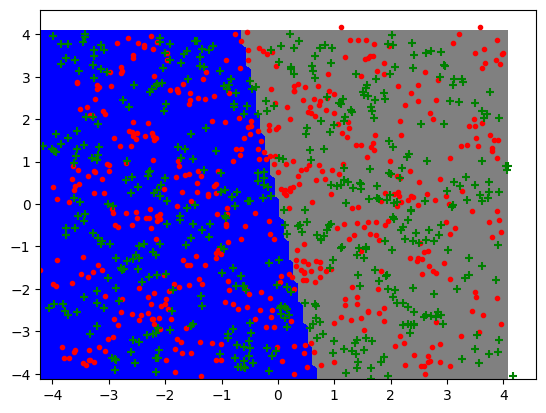

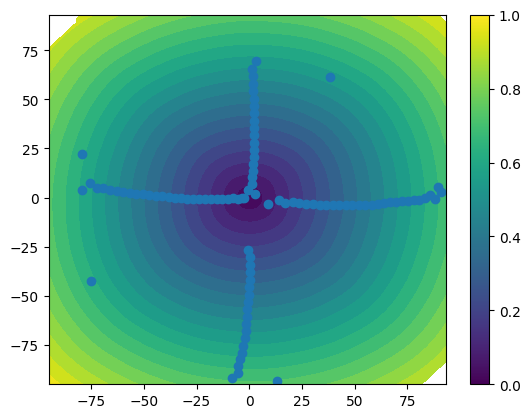

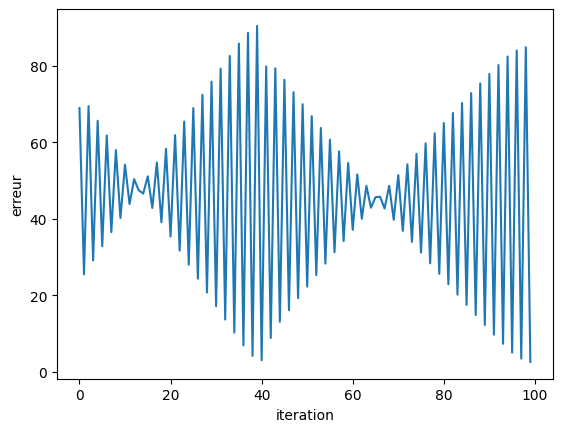

epsilon : 100 et nb_itération : 1000


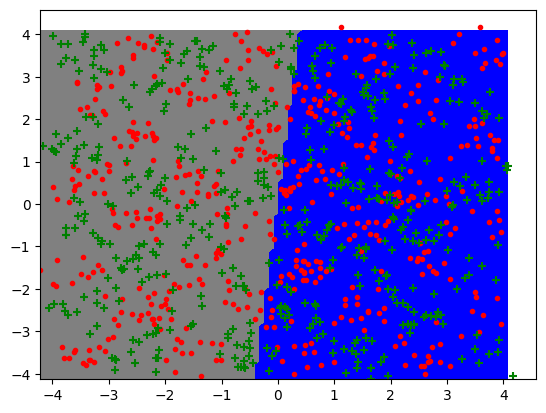

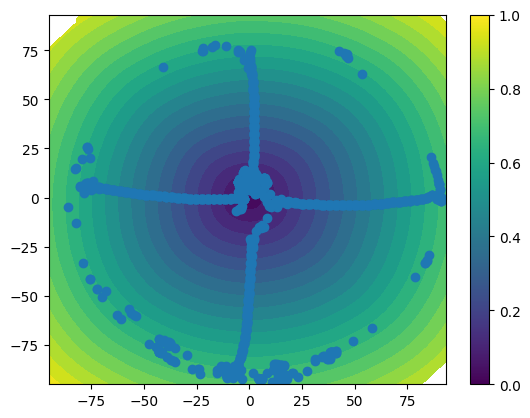

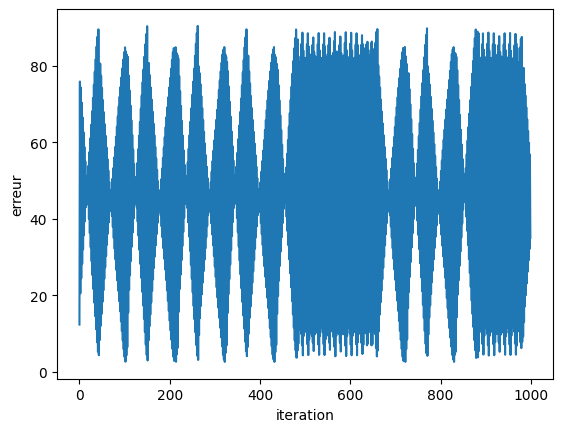

epsilon : 100 et nb_itération : 10000


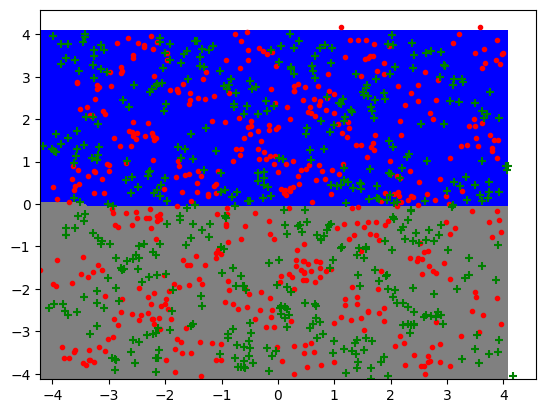

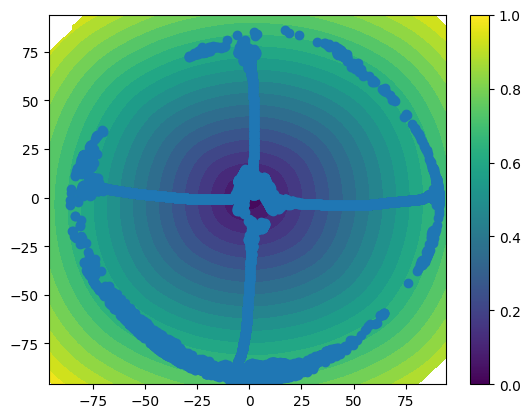

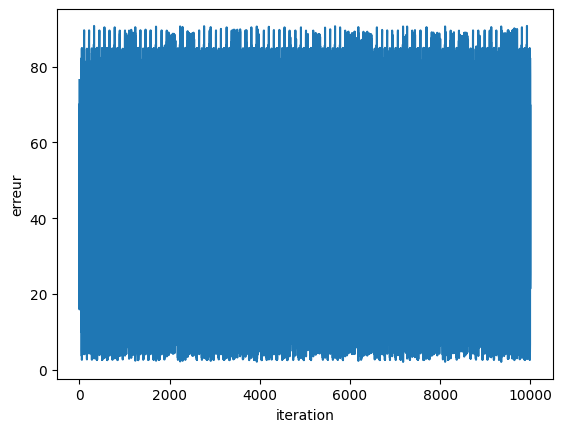

In [14]:
data_type = 2   # int 0-2
epsilon =0.1   # regler bruit

## Tirage d'un jeu de données aléatoire bruit faible
datax, datay = gen_arti(data_type = 2,epsilon=epsilon)

## Apprentissage
for i in [1e-2,1,100]:
    for j in [100,1000,10000]:
        eps= i             # regler le pas
        iteration = j    # regler iteration
        w, liste_w,liste_error = descente_gradient(datax,datay,reglog,reglog_grad,eps,iteration)
        print(f'epsilon : {eps} et nb_itération : {iteration}')
        ## Visualisation des données et de la frontière de décision pour un vecteur de poids w
        plt.figure()
        plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
        plot_data(datax,datay)


        ## Visualisation de la fonction de coût en 2D
        ## Fabrication d'une grille de discrétisation pour la visualisation de la fonction de coût
        lim = np.ceil(np.max(np.abs(liste_w))+1)
        grid, x_grid, y_grid = make_grid(xmin=-lim, xmax=lim, ymin=-lim, ymax=lim, step=100)
        plt.figure()
        plt.contourf(x_grid,y_grid,np.array([reglog(w,datax,datay).mean() for w in grid]).reshape(x_grid.shape),levels=20)
        plt.scatter(liste_w[:,0],liste_w[:,1])
        plt.colorbar()

        ## Evolution de l'erreur
        plt.figure()
        plt.plot(liste_error)
        plt.xlabel("iteration")
        plt.ylabel("erreur")
        plt.show()
        plt.close

In [ ]:
# ici impossible de trouver une frontière de decision unique 